# Previsione della Qualità dell'Aria - **Allenamento con Dati Augmentati e Valutazione dei Modelli**

## Caricamento dei Datasets ed Import Librerie



In [1]:
!pip install pykan

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import json
import inspect
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import types
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.utils.prune as prune
from torch.nn.functional import softmax

%pip install xgboost
import xgboost as xgb
from kan import *

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [4]:
github_url = 'https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/augmented_dataset.csv'
local_path = '/scratch.hpc/martin.tomassi/datasets_pm'
local_file = os.path.join(local_path, 'augmented_dataset.csv')

if not os.path.exists(local_path):
    os.makedirs(local_path)

if not os.path.exists(local_file):
    df = pd.read_csv(github_url,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)
    df.to_csv(local_file, index=False)
    print("File scaricato e salvato in locale.")
else:
    print("Il file esiste già in locale, lo carico...")
    df = pd.read_csv(local_file,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)

obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2018)]
df = df.reset_index(drop=True)
df.head()

File scaricato e salvato in locale.


,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,pm_lag_1D,co_lag_1D,o3_lag_1D,pm_lag_2D,co_lag_2D,o3_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,Class
0,2018,1,1,Bihar,248.338542,1.253194,25.368750,0,1,1,...,205.467292,1.088611,23.453125,265.163333,1.719167,12.699167,234.609375,1.699861,11.677917,6
1,2018,1,1,Tamil Nadu,50.512778,0.000000,28.469167,0,1,1,...,50.147639,0.278125,27.075833,52.587361,0.406042,19.662500,52.804028,0.370625,34.823542,3
2,2018,1,1,Gujarat,84.484167,0.863750,44.890000,0,1,1,...,83.526250,0.887500,64.475833,81.357083,1.103750,51.791667,85.548750,1.254167,56.731667,4
3,2018,1,1,Karnataka,28.918750,1.043403,29.253333,0,1,1,...,17.182083,1.023889,31.423333,26.191875,1.059931,33.975000,32.028125,1.121285,17.305000,2
4,2018,1,1,Haryana,268.927958,2.254875,9.073646,0,1,1,...,210.708229,2.582917,11.671111,186.380208,1.990833,13.275486,166.942153,1.764583,17.315556,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38649 entries, 0 to 38648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        38649 non-null  int64   
 1   month       38649 non-null  int64   
 2   dayofmonth  38649 non-null  int64   
 3   state       38649 non-null  category
 4   PM2.5       38649 non-null  float64 
 5   CO          38649 non-null  float64 
 6   O3          38649 non-null  float64 
 7   dayofweek   38649 non-null  int64   
 8   quarter     38649 non-null  int64   
 9   weekofyear  38649 non-null  int64   
 10  dayofyear   38649 non-null  int64   
 11  pm_lag_1Y   33429 non-null  float64 
 12  co_lag_1Y   33429 non-null  float64 
 13  o3_lag_1Y   33429 non-null  float64 
 14  pm_lag_2Y   29654 non-null  float64 
 15  co_lag_2Y   29654 non-null  float64 
 16  o3_lag_2Y   29654 non-null  float64 
 17  pm_lag_1M   38229 non-null  float64 
 18  co_lag_1M   38229 non-null  float64 
 19  o3_l

In [6]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
2    16578
4    10104
3     7844
1     2014
5     1762
6      347
Name: count, dtype: int64


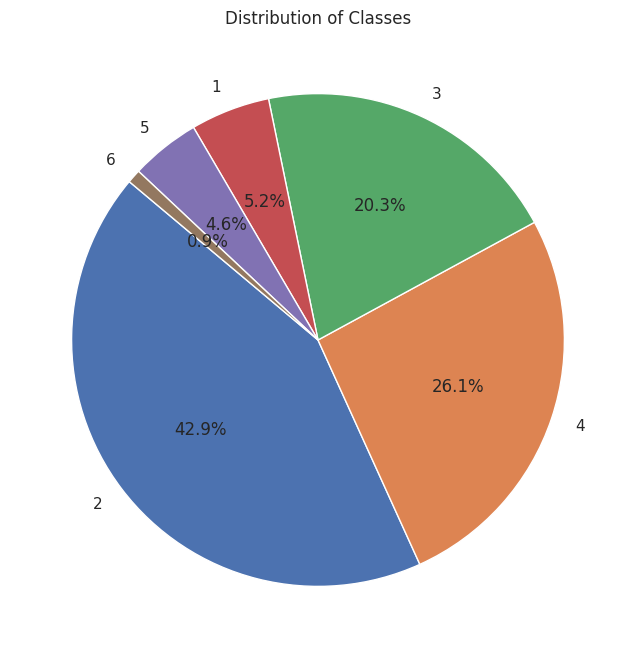

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni

La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [8]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [9]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [10]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/scratch.hpc/martin.tomassi/venv_pm_aug/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23723 entries, 0 to 23722
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  23723 non-null  int64   
 1   dayofweek   23723 non-null  int64   
 2   dayofyear   23723 non-null  int64   
 3   weekofyear  23723 non-null  int64   
 4   month       23723 non-null  int64   
 5   quarter     23723 non-null  int64   
 6   year        23723 non-null  int64   
 7   state       23723 non-null  category
 8   pm_lag_1Y   23723 non-null  float64 
 9   pm_lag_2Y   23723 non-null  float64 
 10  pm_lag_1M   23723 non-null  float64 
 11  pm_lag_1W   23723 non-null  float64 
 12  co_lag_1Y   23723 non-null  float64 
 13  co_lag_2Y   23723 non-null  float64 
 14  co_lag_1M   23723 non-null  float64 
 15  co_lag_1W   23723 non-null  float64 
 16  o3_lag_1Y   23723 non-null  float64 
 17  o3_lag_2Y   23723 non-null  float64 
 18  o3_lag_1M   23723 non-null  float64 
 19  o3_l

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5931 entries, 0 to 5930
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  5931 non-null   int64   
 1   dayofweek   5931 non-null   int64   
 2   dayofyear   5931 non-null   int64   
 3   weekofyear  5931 non-null   int64   
 4   month       5931 non-null   int64   
 5   quarter     5931 non-null   int64   
 6   year        5931 non-null   int64   
 7   state       5931 non-null   category
 8   pm_lag_1Y   5931 non-null   float64 
 9   pm_lag_2Y   5931 non-null   float64 
 10  pm_lag_1M   5931 non-null   float64 
 11  pm_lag_1W   5931 non-null   float64 
 12  co_lag_1Y   5931 non-null   float64 
 13  co_lag_2Y   5931 non-null   float64 
 14  co_lag_1M   5931 non-null   float64 
 15  co_lag_1W   5931 non-null   float64 
 16  o3_lag_1Y   5931 non-null   float64 
 17  o3_lag_2Y   5931 non-null   float64 
 18  o3_lag_1M   5931 non-null   float64 
 19  o3_lag

In [13]:
print(y_train.value_counts())

Class
2    9517
4    7041
3    5320
5    1395
6     312
1     138
Name: count, dtype: int64


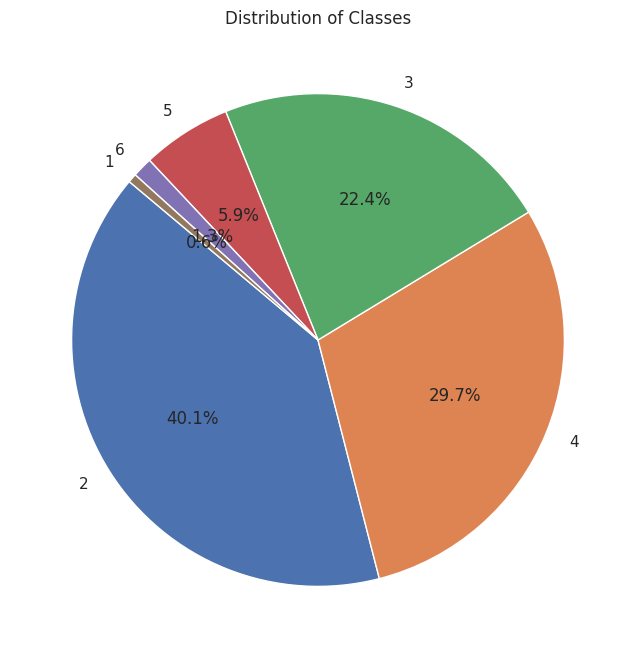

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [15]:
print(y_test.value_counts())

Class
2    2934
4    1445
3    1101
1     282
5     151
6      18
Name: count, dtype: int64


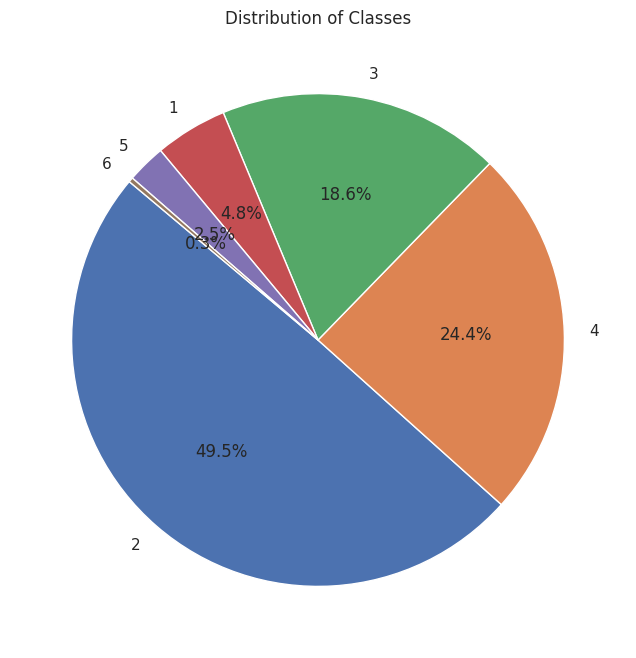

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [17]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [18]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [19]:
def count_params(model):
    if isinstance(model, ImbPipeline):
        model = model.steps[-1][1]

    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0
            else:
                sum_edge_terms = 0
                for i in range(len(model.width) - 1):
                    Nl = model.width[i]
                    Nl_plus_1 = model.width[i+1]
                    if isinstance(Nl, list): Nl = Nl[0]
                    if isinstance(Nl_plus_1, list): Nl_plus_1 = Nl_plus_1[0]
                    G = model.grid
                    k = model.k
                    sum_edge_terms += Nl * Nl_plus_1 * (G + k - 1)
                return sum_edge_terms
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestClassifier):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBClassifier):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Calcola la Complessitá dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters/Nodes: {param_count}")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Calcola il numero di Parametri dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


Fold 1:
-- Training set class distribution: --
Class
1       2
2    1009
3     958
4    1510
5     398
6      81
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      35
2    1280
3    1140
4    1229
5     197
6      72
Name: count, dtype: int64
--------------------
Fold 2:
-- Training set class distribution: --
Class
1      37
2    2289
3    2098
4    2739
5     595
6     153
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      20
2    1275
3     908
4    1423
5     263
6      64
Name: count, dtype: int64
--------------------
Fold 3:
-- Training set class distribution: --
Class
1      57
2    3564
3    3006
4    4162
5     858
6     217
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      44
2    2405
3     687
4     647
5     128
6      42
Name: count, dtype: int64
--------------------


Fold 4:
-- Training set class distribution: --
Class
1     101
2    5969
3    3693
4    4809
5     986
6     259
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      21
2    2013
3     859
4     907
5     143
6      10
Name: count, dtype: int64
--------------------
Fold 5:
-- Training set class distribution: --
Class
1     122
2    7982
3    4552
4    5716
5    1129
6     269
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      16
2    1535
3     768
4    1325
5     266
6      43
Name: count, dtype: int64
--------------------


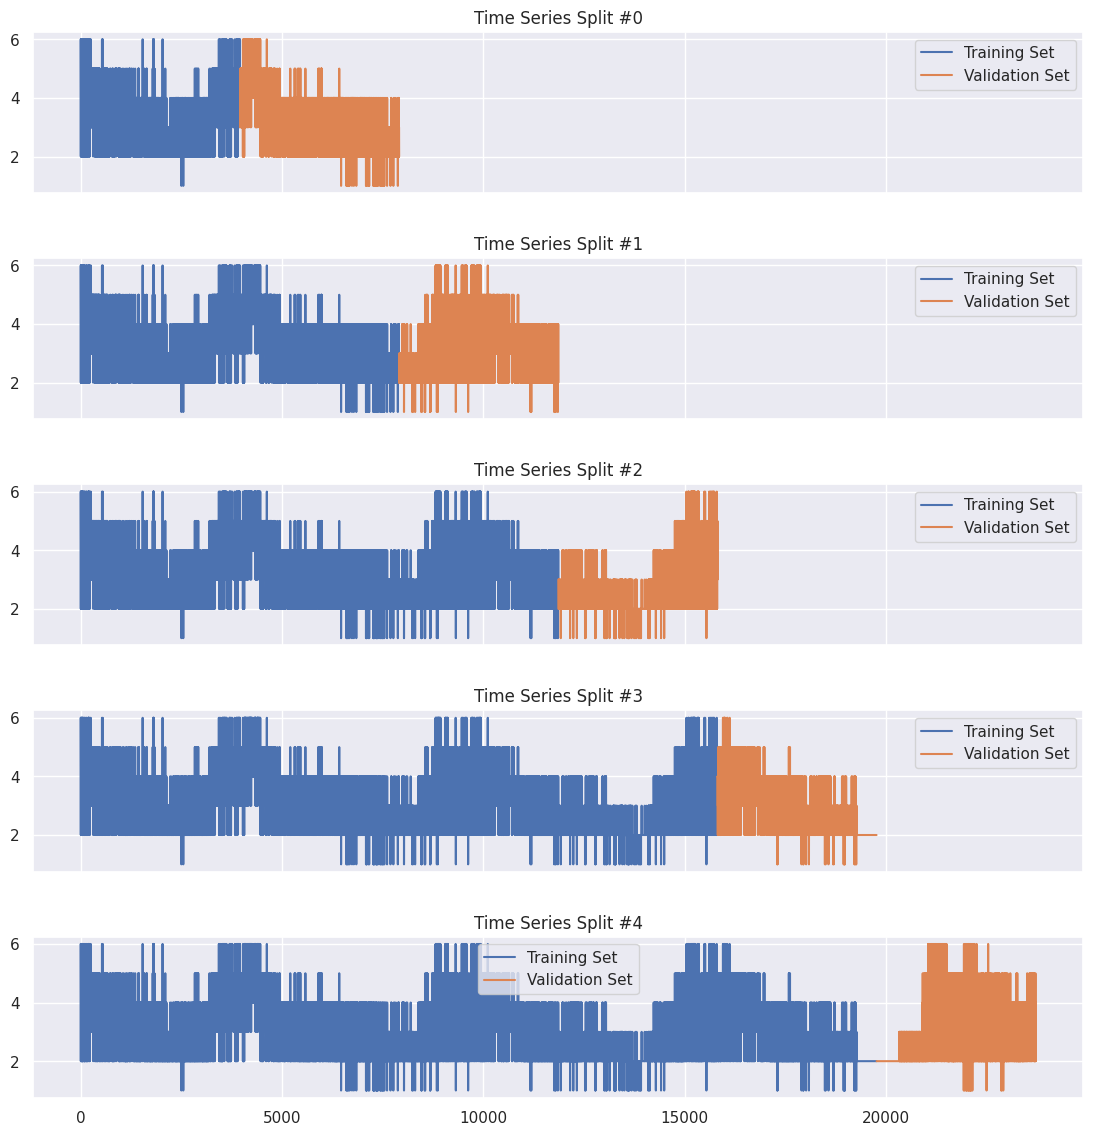

In [21]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

    print(f"Fold {index+1}:")
    print("-- Training set class distribution: --")
    print(y_train.iloc[train_fold].value_counts().sort_index())
    print("-- Validation set class distribution: --")
    print(y_train.iloc[validation_fold].value_counts().sort_index())
    print("-" * 20)

plt.show()

## Custom SMOTE for Random Forest and XGBoost

In [22]:
class SmoteKNeighbors(SMOTE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _fit_resample(self, X, y):
        counts = np.bincount(y)
        minority_class = np.argmin(counts)
        n_samples_minority = counts[minority_class]
        
        if self.k_neighbors >= n_samples_minority:
            new_k_neighbors = max(1, n_samples_minority - 1)
            
            original_k_neighbors = self.k_neighbors
            self.k_neighbors = new_k_neighbors
            
            print(f"Warning: k_neighbors too high. Adjusting from {original_k_neighbors} to {self.k_neighbors} for this fold.")
            
            X_res, y_res = super()._fit_resample(X, y)
            
            self.k_neighbors = original_k_neighbors
            
            return X_res, y_res
        else:
            return super()._fit_resample(X, y)

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [23]:
model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [24]:
%time model.fit(X_train, y_train)
print()

CPU times: user 19.4 s, sys: 206 ms, total: 19.6 s
Wall time: 5.29 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [25]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D    0.200724
numeric__pm_lag_2D    0.113776
numeric__pm_lag_3D    0.093622
numeric__pm_lag_1W    0.057216
numeric__pm_lag_1Y    0.042735
numeric__pm_lag_1M    0.039664
numeric__co_lag_1D    0.038729
numeric__pm_lag_2Y    0.038703
numeric__co_lag_2D    0.026083
numeric__co_lag_3D    0.023355
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

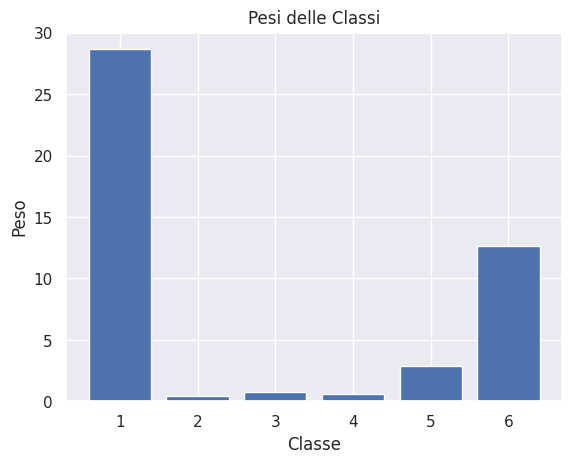

In [26]:
class_labels = np.unique(y_train)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [27]:
grid_rf = {
    'tree__n_estimators': [100, 150, 200],
    'tree__max_samples': [0.5, 0.7, 0.9],
    'tree__max_depth': [5, 10, 15],
    'tree__min_samples_split': [2, 5],
    'tree__min_samples_leaf': [2, 5],
    'tree__max_features': ['sqrt', 'log2']
}

model_ht_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

gs_rf = RandomizedSearchCV(model_ht_rf, grid_rf, n_iter=49, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 216
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 216.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{216}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{206}{216}\right)} = \frac{-2.3026}{\ln(206/216)} \approx \frac{2.3026}{0.0474} \approx 48.58
$$

Quindi, con **49 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 216 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [28]:
%time gs_rf.fit(X_train, y_train)
print()

CPU times: user 43.7 s, sys: 986 ms, total: 44.7 s
Wall time: 12min 39s



In [29]:
get_estimator_scores("random_forest", gs_rf.best_estimator_, X_test, y_test, X_train, y_train, all_scores)


--- Valutazione Prestazioni per random_forest ---
Model Parameters/Nodes: 698284



Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.20      0.01      0.01       282
           2       0.84      0.90      0.87      2934
           3       0.60      0.67      0.63      1101
           4       0.88      0.81      0.84      1445
           5       0.67      0.84      0.74       151
           6       0.41      0.39      0.40        18

    accuracy                           0.79      5931
   macro avg       0.60      0.60      0.58      5931
weighted avg       0.77      0.79      0.77      5931


Confusion Matrix (Test Set):
[[   2  280    0    0    0    0]
 [   8 2632  286    8    0    0]
 [   0  220  740  141    0    0]
 [   0    7  207 1177   53    1]
 [   0    0    0   15  127    9]
 [   0    0    0    1   10    7]]


AUC-ROC (OVR, Weighted): 0.937
AUC-PR (OVR, Weighted): 0.833


## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [30]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

In [31]:
%time model.fit(X_train, y_train_xgb)
print()

CPU times: user 50.6 s, sys: 461 ms, total: 51.1 s
Wall time: 14.6 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [32]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D                   0.393972
categorical__state_Madhya Pradesh    0.038544
categorical__state_Odisha            0.035341
categorical__state_Gujarat           0.025341
categorical__state_Delhi             0.022707
categorical__state_Uttar Pradesh     0.020796
numeric__year                        0.020464
numeric__quarter                     0.018986
numeric__dayofweek                   0.018078
categorical__state_Andhra Pradesh    0.017844
dtype: float32

### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 432
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 432.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{432}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{422}{432}\right)} = \frac{-2.3026}{\ln(\frac{422}{432})} \approx \frac{2.3026}{0.0234} \approx 98.40
$$

Quindi, con **98** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 432 combinazioni.

---

In [33]:
grid_xgb = {
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__gamma": [0, 0.2, 0.4],
    "xgb__min_child_weight": [1, 5]
}

model_ht_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False,
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

gs_xgb = RandomizedSearchCV(model_ht_xgb, grid_xgb, n_iter=98, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

In [34]:
%time gs_xgb.fit(X_train, y_train_xgb)
print()

CPU times: user 30.9 s, sys: 2.37 s, total: 33.3 s
Wall time: 22min 35s



In [35]:
get_estimator_scores("xgboost", gs_xgb.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---
Model Parameters/Nodes: 26592



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.35      0.06      0.11       282
           1       0.84      0.90      0.87      2934
           2       0.62      0.65      0.63      1101
           3       0.86      0.83      0.85      1445
           4       0.65      0.81      0.72       151
           5       0.39      0.50      0.44        18

    accuracy                           0.79      5931
   macro avg       0.62      0.63      0.60      5931
weighted avg       0.78      0.79      0.78      5931


Confusion Matrix (Test Set):
[[  18  264    0    0    0    0]
 [  33 2639  249   13    0    0]
 [   1  229  712  159    0    0]
 [   0    4  189 1194   57    1]
 [   0    0    0   15  123   13]
 [   0    0    0    0    9    9]]


AUC-ROC (OVR, Weighted): 0.935
AUC-PR (OVR, Weighted): 0.813


## MLP and KAN


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, num_classes, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [num_classes],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

Device utilizzato: cuda


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [37]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [38]:
def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [39]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None,
                  smote_k_neighbors=6):
    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Randomized Search")

    smote = SMOTE(
        k_neighbors=smote_k_neighbors,
        random_state=RANDOM_STATE
    )

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Estrai i dati del fold di training
            train_features = dataset.tensors[0][train_idx].cpu().numpy()
            train_labels = dataset.tensors[1][train_idx].cpu().numpy()

            # Estrai i dati di validazione
            val_features = dataset.tensors[0][val_idx]
            val_labels = dataset.tensors[1][val_idx]

            # Applica SMOTE al training set
            try:
                # Verifica che ci siano almeno 2 classi nel training set
                unique_classes = np.unique(train_labels)
                if len(unique_classes) < 2:
                    print(f"    Warning: Solo {len(unique_classes)} classe/i nel fold {fold_idx+1}. Skip SMOTE.")
                    train_features_resampled = train_features
                    train_labels_resampled = train_labels
                else:
                    # Verifica che ogni classe abbia almeno k_neighbors+1 campioni
                    min_samples = min([np.sum(train_labels == cls) for cls in unique_classes])
                    if min_samples <= smote_k_neighbors:
                        print(f"    Warning: Alcune classi hanno meno di {smote_k_neighbors+1} campioni. Riduco k_neighbors.")
                        smote_fold = SMOTE(
                            k_neighbors=min(min_samples-1, 1),
                            random_state=RANDOM_STATE
                        )
                    else:
                        smote_fold = smote

                    train_features_resampled, train_labels_resampled = smote_fold.fit_resample(
                        train_features, train_labels
                    )

                    print(f"    SMOTE applicato: {len(train_features)} -> {len(train_features_resampled)} campioni")

                    # Mostra la distribuzione delle classi dopo SMOTE
                    unique, counts = np.unique(train_labels_resampled, return_counts=True)
                    print(f"    Distribuzione post-SMOTE: {{{', '.join(f'{u}: {c}' for u, c in zip(unique, counts))}}}")

            except Exception as e:
                print(f"    Warning: SMOTE fallito ({str(e)}). Uso dataset originale.")
                train_features_resampled = train_features
                train_labels_resampled = train_labels

            # Converti back a tensori PyTorch
            train_features_tensor = torch.FloatTensor(train_features_resampled)
            train_labels_tensor = torch.LongTensor(train_labels_resampled)

            # Crea i dataset bilanciati
            balanced_train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_features, val_labels)

            # Crea i DataLoader
            train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            # Inizializza e addestra il modello
            model = model_builder(**model_params)
            if hasattr(model, 'speed'):
                model.speed()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(1000):
                train_loss = train_epoch(model, train_loader, optimizer, criterion, l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [40]:
X_train_processed = preprocessor.fit_transform(X_train) # Fit and transform on training data
X_test_processed = preprocessor.transform(X_test) # Only transform on test data

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(64,64), (128,), (128, 64), (256, 128), (512, 256)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}
kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16, 8), (32, 16), (64, 32)],
    'grid': [5, 10, 20],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [41]:
%%time
print("MLP Results:")
best_model_mlp, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=26
)

MLP Results:
Avvio Randomized Search
Testing parameter set 1/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.979600, val_loss = 0.874633


    Early stopping at epoch 9, best_val_loss: 0.739445
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.866066, val_loss = 0.877754


    Epoch 10: train_loss = 0.420469, val_loss = 0.845678


    Early stopping at epoch 11, best_val_loss: 0.757424
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.799532, val_loss = 0.904978


    Early stopping at epoch 9, best_val_loss: 0.637511
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.758826, val_loss = 0.757890


    Epoch 10: train_loss = 0.410309, val_loss = 0.563137
    Early stopping at epoch 10, best_val_loss: 0.537486
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.714512, val_loss = 0.635202


    Early stopping at epoch 8, best_val_loss: 0.477157
  Mean validation loss: 0.669048
  New best validation loss: 0.669048
Testing parameter set 2/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.594302, val_loss = 1.639257


    Epoch 10: train_loss = 0.689697, val_loss = 0.893850


    Epoch 20: train_loss = 0.580670, val_loss = 0.819287


    Epoch 30: train_loss = 0.538459, val_loss = 0.798192


    Epoch 40: train_loss = 0.501763, val_loss = 0.784880


    Epoch 50: train_loss = 0.476493, val_loss = 0.772603


    Early stopping at epoch 52, best_val_loss: 0.768705
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.457906, val_loss = 1.531233


    Epoch 10: train_loss = 0.637732, val_loss = 0.901955


    Epoch 20: train_loss = 0.571902, val_loss = 0.835234


    Epoch 30: train_loss = 0.533699, val_loss = 0.810719


    Epoch 40: train_loss = 0.508699, val_loss = 0.780459


    Early stopping at epoch 42, best_val_loss: 0.771141
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.402452, val_loss = 1.369343


    Epoch 10: train_loss = 0.617317, val_loss = 0.831210


    Epoch 20: train_loss = 0.551237, val_loss = 0.729171


    Epoch 30: train_loss = 0.516734, val_loss = 0.663618


    Epoch 40: train_loss = 0.490418, val_loss = 0.620836


    Early stopping at epoch 44, best_val_loss: 0.605279
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.270258, val_loss = 1.206375


    Epoch 10: train_loss = 0.599593, val_loss = 0.735234


    Epoch 20: train_loss = 0.534150, val_loss = 0.617421


    Epoch 30: train_loss = 0.495164, val_loss = 0.567837


    Epoch 40: train_loss = 0.468519, val_loss = 0.540338


    Epoch 50: train_loss = 0.449537, val_loss = 0.520972


    Early stopping at epoch 52, best_val_loss: 0.516685
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.185180, val_loss = 1.168698


    Epoch 10: train_loss = 0.563670, val_loss = 0.555885


    Epoch 20: train_loss = 0.496827, val_loss = 0.467931


    Early stopping at epoch 29, best_val_loss: 0.458561
  Mean validation loss: 0.633209
  New best validation loss: 0.633209
Testing parameter set 3/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.886847, val_loss = 0.867817


    Early stopping at epoch 9, best_val_loss: 0.765709
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.776862, val_loss = 0.878779


    Epoch 10: train_loss = 0.352264, val_loss = 0.814711


    Early stopping at epoch 11, best_val_loss: 0.742591
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.707055, val_loss = 0.766389


    Epoch 10: train_loss = 0.349029, val_loss = 0.698732


    Early stopping at epoch 11, best_val_loss: 0.529002
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.673641, val_loss = 0.738337


    Epoch 10: train_loss = 0.328951, val_loss = 0.515199


    Early stopping at epoch 13, best_val_loss: 0.512464
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.623541, val_loss = 0.520635


    Early stopping at epoch 7, best_val_loss: 0.485201
  Mean validation loss: 0.679558
Testing parameter set 4/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.476366, val_loss = 1.563165


    Epoch 10: train_loss = 0.676420, val_loss = 0.930847


    Epoch 20: train_loss = 0.562517, val_loss = 0.838972


    Epoch 30: train_loss = 0.507190, val_loss = 0.801497


    Epoch 40: train_loss = 0.472956, val_loss = 0.783183


    Epoch 50: train_loss = 0.449019, val_loss = 0.779354
    Early stopping at epoch 50, best_val_loss: 0.776751
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.350344, val_loss = 1.532028


    Epoch 10: train_loss = 0.619371, val_loss = 0.950898


    Epoch 20: train_loss = 0.545199, val_loss = 0.857436


    Epoch 30: train_loss = 0.502027, val_loss = 0.809831


    Epoch 40: train_loss = 0.473875, val_loss = 0.780374


    Epoch 50: train_loss = 0.454714, val_loss = 0.772767


    Early stopping at epoch 51, best_val_loss: 0.766592
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.328154, val_loss = 1.381423


    Epoch 10: train_loss = 0.595212, val_loss = 0.895374


    Epoch 20: train_loss = 0.525729, val_loss = 0.776837


    Epoch 30: train_loss = 0.488860, val_loss = 0.741055


    Epoch 40: train_loss = 0.466999, val_loss = 0.673914


    Epoch 50: train_loss = 0.449086, val_loss = 0.658817


    Epoch 60: train_loss = 0.436786, val_loss = 0.629316


    Epoch 70: train_loss = 0.424334, val_loss = 0.607717


    Epoch 80: train_loss = 0.416215, val_loss = 0.594248


    Early stopping at epoch 81, best_val_loss: 0.588550
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.224224, val_loss = 1.195298


    Epoch 10: train_loss = 0.573638, val_loss = 0.749867


    Epoch 20: train_loss = 0.508334, val_loss = 0.646311


    Epoch 30: train_loss = 0.472618, val_loss = 0.590284


    Epoch 40: train_loss = 0.450660, val_loss = 0.567605


    Epoch 50: train_loss = 0.433027, val_loss = 0.541202


    Epoch 60: train_loss = 0.419520, val_loss = 0.523644


    Epoch 70: train_loss = 0.409873, val_loss = 0.518628


    Epoch 80: train_loss = 0.401483, val_loss = 0.511074


    Early stopping at epoch 89, best_val_loss: 0.505277
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.159691, val_loss = 1.211200


    Epoch 10: train_loss = 0.538040, val_loss = 0.619864


    Epoch 20: train_loss = 0.471832, val_loss = 0.522409


    Epoch 30: train_loss = 0.440401, val_loss = 0.490203


    Epoch 40: train_loss = 0.418951, val_loss = 0.477070


    Early stopping at epoch 48, best_val_loss: 0.474547
  Mean validation loss: 0.623952
  New best validation loss: 0.623952
Testing parameter set 5/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.707277, val_loss = 0.797667


    Early stopping at epoch 6, best_val_loss: 0.772864
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.661067, val_loss = 0.865611


    Early stopping at epoch 8, best_val_loss: 0.767797
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.623533, val_loss = 0.648626


    Early stopping at epoch 7, best_val_loss: 0.541952
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.584255, val_loss = 0.616596


    Epoch 10: train_loss = 0.245227, val_loss = 0.551581
    Early stopping at epoch 10, best_val_loss: 0.515150
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.548075, val_loss = 0.512282


    Early stopping at epoch 6, best_val_loss: 0.489259
  Mean validation loss: 0.729556
Testing parameter set 6/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.765911, val_loss = 0.832369


    Early stopping at epoch 6, best_val_loss: 0.750359
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.711407, val_loss = 0.883117


    Early stopping at epoch 7, best_val_loss: 0.778204
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.671044, val_loss = 0.855357


    Epoch 10: train_loss = 0.340415, val_loss = 0.579117


    Early stopping at epoch 12, best_val_loss: 0.543334
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.642899, val_loss = 0.647715


    Epoch 10: train_loss = 0.323409, val_loss = 0.561666
    Early stopping at epoch 10, best_val_loss: 0.504721
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.602222, val_loss = 0.496118


    Early stopping at epoch 6, best_val_loss: 0.472244
  Mean validation loss: 0.676135
Testing parameter set 7/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.112885, val_loss = 1.055721


    Epoch 10: train_loss = 0.427138, val_loss = 0.791914


    Early stopping at epoch 13, best_val_loss: 0.776036
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.973758, val_loss = 1.041893


    Epoch 10: train_loss = 0.433560, val_loss = 0.757600


    Early stopping at epoch 16, best_val_loss: 0.743514
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.904464, val_loss = 0.960779


    Epoch 10: train_loss = 0.424771, val_loss = 0.580469


    Epoch 20: train_loss = 0.357726, val_loss = 0.548926


    Early stopping at epoch 24, best_val_loss: 0.548391
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.835567, val_loss = 0.832112


    Epoch 10: train_loss = 0.397227, val_loss = 0.530752


    Epoch 20: train_loss = 0.330199, val_loss = 0.495201


    Early stopping at epoch 25, best_val_loss: 0.495201
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.778746, val_loss = 0.688303


    Epoch 10: train_loss = 0.372423, val_loss = 0.488719
    Early stopping at epoch 10, best_val_loss: 0.469731
  Mean validation loss: 0.620387
  New best validation loss: 0.620387
Testing parameter set 8/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.913073, val_loss = 0.954124


    Epoch 10: train_loss = 0.338856, val_loss = 0.892212
    Early stopping at epoch 10, best_val_loss: 0.799081
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.801537, val_loss = 1.015017


    Epoch 10: train_loss = 0.351591, val_loss = 0.805505
    Early stopping at epoch 10, best_val_loss: 0.784349
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.755545, val_loss = 0.972800


    Epoch 10: train_loss = 0.353468, val_loss = 0.618705


    Early stopping at epoch 19, best_val_loss: 0.606320
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.698673, val_loss = 0.792085


    Epoch 10: train_loss = 0.329133, val_loss = 0.534014
    Early stopping at epoch 10, best_val_loss: 0.517599
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.655689, val_loss = 0.595687


    Early stopping at epoch 7, best_val_loss: 0.473854
  Mean validation loss: 0.674188
Testing parameter set 9/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.970746, val_loss = 0.909882


    Early stopping at epoch 8, best_val_loss: 0.783680
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.850887, val_loss = 0.880590


    Early stopping at epoch 8, best_val_loss: 0.758506
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.798930, val_loss = 0.968446


    Epoch 10: train_loss = 0.424675, val_loss = 0.617274


    Early stopping at epoch 12, best_val_loss: 0.586376
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.755361, val_loss = 0.714557


    Early stopping at epoch 9, best_val_loss: 0.530877
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.706553, val_loss = 0.621748


    Early stopping at epoch 9, best_val_loss: 0.481256
  Mean validation loss: 0.660341
Testing parameter set 10/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.457003, val_loss = 1.429974


    Epoch 10: train_loss = 0.633647, val_loss = 0.821116


    Epoch 20: train_loss = 0.539087, val_loss = 0.777451


    Epoch 30: train_loss = 0.488012, val_loss = 0.773774


    Early stopping at epoch 34, best_val_loss: 0.762797
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.293746, val_loss = 1.385442


    Epoch 10: train_loss = 0.605964, val_loss = 0.882470


    Epoch 20: train_loss = 0.528188, val_loss = 0.810505


    Epoch 30: train_loss = 0.484625, val_loss = 0.784815


    Early stopping at epoch 35, best_val_loss: 0.784815
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.227293, val_loss = 1.219099


    Epoch 10: train_loss = 0.584411, val_loss = 0.778692


    Epoch 20: train_loss = 0.510657, val_loss = 0.693460


    Early stopping at epoch 29, best_val_loss: 0.656248
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.134432, val_loss = 1.087312


    Epoch 10: train_loss = 0.560662, val_loss = 0.616188


    Epoch 20: train_loss = 0.488948, val_loss = 0.534425


    Epoch 30: train_loss = 0.443180, val_loss = 0.514959


    Early stopping at epoch 35, best_val_loss: 0.514959
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.058908, val_loss = 1.002479


    Epoch 10: train_loss = 0.521237, val_loss = 0.506358


    Epoch 20: train_loss = 0.451749, val_loss = 0.461337


    Early stopping at epoch 25, best_val_loss: 0.461337
  Mean validation loss: 0.643519
Testing parameter set 11/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.803064, val_loss = 0.837929


    Early stopping at epoch 7, best_val_loss: 0.757043
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.723606, val_loss = 0.863783


    Early stopping at epoch 8, best_val_loss: 0.744311
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.671781, val_loss = 0.766070


    Epoch 10: train_loss = 0.312919, val_loss = 0.625084


    Early stopping at epoch 11, best_val_loss: 0.565055
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.628241, val_loss = 0.685771


    Epoch 10: train_loss = 0.293012, val_loss = 0.553654


    Early stopping at epoch 11, best_val_loss: 0.511622
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.593039, val_loss = 0.465890


    Early stopping at epoch 5, best_val_loss: 0.465890
  Mean validation loss: 0.694011
Testing parameter set 12/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.893288, val_loss = 0.929819


    Early stopping at epoch 9, best_val_loss: 0.753305
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.810958, val_loss = 0.878029


    Epoch 10: train_loss = 0.420001, val_loss = 0.826518


    Early stopping at epoch 12, best_val_loss: 0.753789
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.766306, val_loss = 0.841655


    Epoch 10: train_loss = 0.426786, val_loss = 0.635758


    Early stopping at epoch 12, best_val_loss: 0.538526
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.719297, val_loss = 0.749730


    Epoch 10: train_loss = 0.418355, val_loss = 0.514179


    Early stopping at epoch 15, best_val_loss: 0.514179
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.674652, val_loss = 0.561103


    Early stopping at epoch 6, best_val_loss: 0.463223
  Mean validation loss: 0.690988
Testing parameter set 13/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.452561, val_loss = 1.560482


    Epoch 10: train_loss = 0.620572, val_loss = 0.907201


    Epoch 20: train_loss = 0.504479, val_loss = 0.825936


    Epoch 30: train_loss = 0.447968, val_loss = 0.792667


    Early stopping at epoch 35, best_val_loss: 0.792667
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.313069, val_loss = 1.506583


    Epoch 10: train_loss = 0.570604, val_loss = 0.944705


    Epoch 20: train_loss = 0.493046, val_loss = 0.843129


    Epoch 30: train_loss = 0.449173, val_loss = 0.807456


    Epoch 40: train_loss = 0.419261, val_loss = 0.792389


    Epoch 50: train_loss = 0.396272, val_loss = 0.781153


    Early stopping at epoch 55, best_val_loss: 0.781153
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.292329, val_loss = 1.357182


    Epoch 10: train_loss = 0.548965, val_loss = 0.934481


    Epoch 20: train_loss = 0.478360, val_loss = 0.798300


    Epoch 30: train_loss = 0.439327, val_loss = 0.780998


    Epoch 40: train_loss = 0.413310, val_loss = 0.719547


    Early stopping at epoch 44, best_val_loss: 0.685370
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.199138, val_loss = 1.247085


    Epoch 10: train_loss = 0.524806, val_loss = 0.720714


    Epoch 20: train_loss = 0.452357, val_loss = 0.634028


    Epoch 30: train_loss = 0.415041, val_loss = 0.581246


    Epoch 40: train_loss = 0.388628, val_loss = 0.546399


    Epoch 50: train_loss = 0.368305, val_loss = 0.535339


    Early stopping at epoch 51, best_val_loss: 0.533488
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.110892, val_loss = 1.188138


    Epoch 10: train_loss = 0.484259, val_loss = 0.588734


    Epoch 20: train_loss = 0.417220, val_loss = 0.504151


    Epoch 30: train_loss = 0.381616, val_loss = 0.479218


    Early stopping at epoch 38, best_val_loss: 0.471673
  Mean validation loss: 0.659202
Testing parameter set 14/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.626678, val_loss = 0.928990


    Early stopping at epoch 7, best_val_loss: 0.831416
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.615124, val_loss = 0.806891


    Early stopping at epoch 6, best_val_loss: 0.794051
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.584567, val_loss = 0.673194


    Early stopping at epoch 6, best_val_loss: 0.580533
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.560620, val_loss = 0.757378


    Early stopping at epoch 9, best_val_loss: 0.514428
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.525748, val_loss = 0.501112


    Early stopping at epoch 5, best_val_loss: 0.501112
  Mean validation loss: 0.756798
Testing parameter set 15/26
  Fold 1/5


    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.570816, val_loss = 1.613491


    Epoch 10: train_loss = 0.735196, val_loss = 0.947060


    Epoch 20: train_loss = 0.609900, val_loss = 0.848565


    Epoch 30: train_loss = 0.550812, val_loss = 0.805477


    Epoch 40: train_loss = 0.514011, val_loss = 0.787814


    Epoch 50: train_loss = 0.486743, val_loss = 0.780471


    Early stopping at epoch 53, best_val_loss: 0.777476
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.419969, val_loss = 1.566435


    Epoch 10: train_loss = 0.664919, val_loss = 0.996295


    Epoch 20: train_loss = 0.578427, val_loss = 0.892020


    Epoch 30: train_loss = 0.536156, val_loss = 0.837838


    Epoch 40: train_loss = 0.508246, val_loss = 0.816604


    Epoch 50: train_loss = 0.478730, val_loss = 0.796023


    Epoch 60: train_loss = 0.465905, val_loss = 0.790740


    Early stopping at epoch 68, best_val_loss: 0.779598
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.352913, val_loss = 1.422399


    Epoch 10: train_loss = 0.636207, val_loss = 0.951582


    Epoch 20: train_loss = 0.557732, val_loss = 0.830421


    Epoch 30: train_loss = 0.520290, val_loss = 0.775170


    Epoch 40: train_loss = 0.495038, val_loss = 0.714153


    Epoch 50: train_loss = 0.469071, val_loss = 0.689958


    Epoch 60: train_loss = 0.459040, val_loss = 0.657342


    Early stopping at epoch 65, best_val_loss: 0.657342
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.288912, val_loss = 1.261078


    Epoch 10: train_loss = 0.616024, val_loss = 0.782565


    Epoch 20: train_loss = 0.544322, val_loss = 0.657693


    Epoch 30: train_loss = 0.501416, val_loss = 0.604533


    Epoch 40: train_loss = 0.472765, val_loss = 0.569261


    Epoch 50: train_loss = 0.457027, val_loss = 0.538502


    Epoch 60: train_loss = 0.438496, val_loss = 0.530455


    Early stopping at epoch 64, best_val_loss: 0.524515
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.209136, val_loss = 1.327555


    Epoch 10: train_loss = 0.577634, val_loss = 0.677005


    Epoch 20: train_loss = 0.506955, val_loss = 0.561974


    Epoch 30: train_loss = 0.468446, val_loss = 0.509548


    Epoch 40: train_loss = 0.443441, val_loss = 0.489166


    Epoch 50: train_loss = 0.427482, val_loss = 0.485771


    Early stopping at epoch 54, best_val_loss: 0.480440
  Mean validation loss: 0.647065
Testing parameter set 16/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.517884, val_loss = 1.615887


    Epoch 10: train_loss = 0.734949, val_loss = 0.978776


    Epoch 20: train_loss = 0.613699, val_loss = 0.864611


    Epoch 30: train_loss = 0.550746, val_loss = 0.811281


    Epoch 40: train_loss = 0.514105, val_loss = 0.785747


    Epoch 50: train_loss = 0.487004, val_loss = 0.772027


    Epoch 60: train_loss = 0.464275, val_loss = 0.767322


    Early stopping at epoch 62, best_val_loss: 0.762019
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.398658, val_loss = 1.546858


    Epoch 10: train_loss = 0.669044, val_loss = 1.001718


    Epoch 20: train_loss = 0.585820, val_loss = 0.885212


    Epoch 30: train_loss = 0.540826, val_loss = 0.837234


    Epoch 40: train_loss = 0.511502, val_loss = 0.813502


    Epoch 50: train_loss = 0.490233, val_loss = 0.796240


    Early stopping at epoch 59, best_val_loss: 0.788306
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.356964, val_loss = 1.428287


    Epoch 10: train_loss = 0.641309, val_loss = 0.914958


    Epoch 20: train_loss = 0.565824, val_loss = 0.806809


    Epoch 30: train_loss = 0.521184, val_loss = 0.764102


    Epoch 40: train_loss = 0.495247, val_loss = 0.709346


    Epoch 50: train_loss = 0.476131, val_loss = 0.675348


    Epoch 60: train_loss = 0.461793, val_loss = 0.644277


    Epoch 70: train_loss = 0.445594, val_loss = 0.628293


    Early stopping at epoch 73, best_val_loss: 0.617105
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.257273, val_loss = 1.290824


    Epoch 10: train_loss = 0.615582, val_loss = 0.764167


    Epoch 20: train_loss = 0.540921, val_loss = 0.663105


    Epoch 30: train_loss = 0.497733, val_loss = 0.599826


    Epoch 40: train_loss = 0.471465, val_loss = 0.559108


    Epoch 50: train_loss = 0.452925, val_loss = 0.545750


    Epoch 60: train_loss = 0.436405, val_loss = 0.532538


    Epoch 70: train_loss = 0.423610, val_loss = 0.524140


    Epoch 80: train_loss = 0.414324, val_loss = 0.520374


    Early stopping at epoch 81, best_val_loss: 0.518883
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.211337, val_loss = 1.281505


    Epoch 10: train_loss = 0.579329, val_loss = 0.658741


    Epoch 20: train_loss = 0.503055, val_loss = 0.545040


    Epoch 30: train_loss = 0.464209, val_loss = 0.507452


    Epoch 40: train_loss = 0.439307, val_loss = 0.490993


    Epoch 50: train_loss = 0.422376, val_loss = 0.491523


    Early stopping at epoch 51, best_val_loss: 0.484477
  Mean validation loss: 0.639898
Testing parameter set 17/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.512522, val_loss = 1.538260


    Epoch 10: train_loss = 0.643819, val_loss = 0.829482


    Epoch 20: train_loss = 0.542524, val_loss = 0.767810


    Epoch 30: train_loss = 0.489701, val_loss = 0.767039
    Early stopping at epoch 30, best_val_loss: 0.758331
  Fold 2/5


    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.304552, val_loss = 1.377860


    Epoch 10: train_loss = 0.609307, val_loss = 0.868499


    Epoch 20: train_loss = 0.535975, val_loss = 0.827424


    Early stopping at epoch 28, best_val_loss: 0.793059
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.219811, val_loss = 1.151394


    Epoch 10: train_loss = 0.585529, val_loss = 0.759748


    Epoch 20: train_loss = 0.514346, val_loss = 0.706198


    Epoch 30: train_loss = 0.472281, val_loss = 0.631074


    Epoch 40: train_loss = 0.439128, val_loss = 0.613121


    Early stopping at epoch 44, best_val_loss: 0.599156
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.122428, val_loss = 1.058206


    Epoch 10: train_loss = 0.557382, val_loss = 0.661979


    Epoch 20: train_loss = 0.488609, val_loss = 0.545071


    Epoch 30: train_loss = 0.445578, val_loss = 0.526297


    Epoch 40: train_loss = 0.419674, val_loss = 0.521880
    Early stopping at epoch 40, best_val_loss: 0.520148
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.050689, val_loss = 0.975880


    Epoch 10: train_loss = 0.525569, val_loss = 0.516918


    Epoch 20: train_loss = 0.451646, val_loss = 0.476357


    Early stopping at epoch 23, best_val_loss: 0.475311
  Mean validation loss: 0.636917
Testing parameter set 18/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.879844, val_loss = 0.858713


    Early stopping at epoch 6, best_val_loss: 0.777580
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.784971, val_loss = 0.861105


    Early stopping at epoch 9, best_val_loss: 0.739067
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.713263, val_loss = 0.896779


    Epoch 10: train_loss = 0.341643, val_loss = 0.653315
    Early stopping at epoch 10, best_val_loss: 0.582241
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.672167, val_loss = 0.757703


    Epoch 10: train_loss = 0.328041, val_loss = 0.534363
    Early stopping at epoch 10, best_val_loss: 0.517718
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.617171, val_loss = 0.510647


    Early stopping at epoch 7, best_val_loss: 0.476353
  Mean validation loss: 0.693429
Testing parameter set 19/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.994422, val_loss = 0.961478


    Epoch 10: train_loss = 0.432368, val_loss = 0.764357


    Early stopping at epoch 11, best_val_loss: 0.763639
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.887434, val_loss = 1.027367


    Epoch 10: train_loss = 0.451663, val_loss = 0.770767


    Early stopping at epoch 14, best_val_loss: 0.759749
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.846169, val_loss = 0.907063


    Epoch 10: train_loss = 0.450025, val_loss = 0.606935


    Early stopping at epoch 11, best_val_loss: 0.595234
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.801704, val_loss = 0.813799


    Epoch 10: train_loss = 0.433033, val_loss = 0.527638


    Early stopping at epoch 17, best_val_loss: 0.525781
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.759984, val_loss = 0.699652


    Epoch 10: train_loss = 0.413908, val_loss = 0.525257
    Early stopping at epoch 10, best_val_loss: 0.492218
  Mean validation loss: 0.644196
Testing parameter set 20/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.893619, val_loss = 0.828659


    Epoch 10: train_loss = 0.414058, val_loss = 0.820794


    Early stopping at epoch 11, best_val_loss: 0.757298
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.813008, val_loss = 0.941291


    Epoch 10: train_loss = 0.437223, val_loss = 0.871181


    Early stopping at epoch 13, best_val_loss: 0.801937
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.775537, val_loss = 0.818850


    Epoch 10: train_loss = 0.443765, val_loss = 0.609732


    Early stopping at epoch 11, best_val_loss: 0.593329
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.745217, val_loss = 0.740077


    Epoch 10: train_loss = 0.435800, val_loss = 0.580771


    Early stopping at epoch 12, best_val_loss: 0.537404
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.709998, val_loss = 0.582489


    Early stopping at epoch 8, best_val_loss: 0.473495
  Mean validation loss: 0.688789
Testing parameter set 21/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.329770, val_loss = 1.304960


    Epoch 10: train_loss = 0.509263, val_loss = 0.785154


    Early stopping at epoch 19, best_val_loss: 0.764119
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.163559, val_loss = 1.258168


    Epoch 10: train_loss = 0.511034, val_loss = 0.808799


    Epoch 20: train_loss = 0.436252, val_loss = 0.757884


    Early stopping at epoch 26, best_val_loss: 0.739904
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.074284, val_loss = 1.125558


    Epoch 10: train_loss = 0.488665, val_loss = 0.710034


    Epoch 20: train_loss = 0.423905, val_loss = 0.652189


    Epoch 30: train_loss = 0.386748, val_loss = 0.599505
    Early stopping at epoch 30, best_val_loss: 0.584005
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.975812, val_loss = 0.941167


    Epoch 10: train_loss = 0.457787, val_loss = 0.563880


    Epoch 20: train_loss = 0.393515, val_loss = 0.515827


    Early stopping at epoch 28, best_val_loss: 0.508575
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.905867, val_loss = 0.866745


    Epoch 10: train_loss = 0.429862, val_loss = 0.476385


    Epoch 20: train_loss = 0.366886, val_loss = 0.485191
    Early stopping at epoch 20, best_val_loss: 0.472114
  Mean validation loss: 0.621610
Testing parameter set 22/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.604197, val_loss = 1.656149


    Epoch 10: train_loss = 0.676910, val_loss = 0.855671


    Epoch 20: train_loss = 0.571418, val_loss = 0.787284


    Epoch 30: train_loss = 0.525973, val_loss = 0.758932


    Epoch 40: train_loss = 0.492894, val_loss = 0.746106


    Early stopping at epoch 48, best_val_loss: 0.740370
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.469541, val_loss = 1.574189


    Epoch 10: train_loss = 0.620839, val_loss = 0.925582


    Epoch 20: train_loss = 0.551963, val_loss = 0.835747


    Epoch 30: train_loss = 0.518511, val_loss = 0.833040
    Early stopping at epoch 30, best_val_loss: 0.821315
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.336385, val_loss = 1.324744


    Epoch 10: train_loss = 0.600198, val_loss = 0.872314


    Epoch 20: train_loss = 0.537311, val_loss = 0.755808


    Epoch 30: train_loss = 0.494343, val_loss = 0.724586


    Early stopping at epoch 37, best_val_loss: 0.679322
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 1.238396, val_loss = 1.202134


    Epoch 10: train_loss = 0.575807, val_loss = 0.697777


    Epoch 20: train_loss = 0.506171, val_loss = 0.590181


    Epoch 30: train_loss = 0.468779, val_loss = 0.537906


    Epoch 40: train_loss = 0.439434, val_loss = 0.528554


    Early stopping at epoch 49, best_val_loss: 0.524555
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 1.188967, val_loss = 1.229416


    Epoch 10: train_loss = 0.542177, val_loss = 0.558409


    Epoch 20: train_loss = 0.472222, val_loss = 0.487941


    Epoch 30: train_loss = 0.430351, val_loss = 0.474321


    Early stopping at epoch 35, best_val_loss: 0.474321
  Mean validation loss: 0.658005
Testing parameter set 23/26
  Fold 1/5


    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 1.302618, val_loss = 1.227142


    Epoch 10: train_loss = 0.454760, val_loss = 0.805314


    Early stopping at epoch 19, best_val_loss: 0.778726
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 1.098692, val_loss = 1.147399


    Epoch 10: train_loss = 0.470319, val_loss = 0.776424


    Epoch 20: train_loss = 0.397061, val_loss = 0.763390
    Early stopping at epoch 20, best_val_loss: 0.734463
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 1.040581, val_loss = 1.113834


    Epoch 10: train_loss = 0.452055, val_loss = 0.700534


    Epoch 20: train_loss = 0.390000, val_loss = 0.609602


    Early stopping at epoch 23, best_val_loss: 0.551355
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.932388, val_loss = 0.875338


    Epoch 10: train_loss = 0.430707, val_loss = 0.539922


    Epoch 20: train_loss = 0.368214, val_loss = 0.509199


    Early stopping at epoch 27, best_val_loss: 0.495419
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.866267, val_loss = 0.739860


    Epoch 10: train_loss = 0.397729, val_loss = 0.470410


    Early stopping at epoch 14, best_val_loss: 0.464495
  Mean validation loss: 0.637552
Testing parameter set 24/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.786149, val_loss = 0.850624


    Early stopping at epoch 8, best_val_loss: 0.745885
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.730626, val_loss = 0.864536


    Early stopping at epoch 8, best_val_loss: 0.756645
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.694150, val_loss = 0.733076


    Epoch 10: train_loss = 0.387371, val_loss = 0.647190


    Early stopping at epoch 13, best_val_loss: 0.551599
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.663508, val_loss = 0.666558


    Epoch 10: train_loss = 0.378067, val_loss = 0.546655


    Early stopping at epoch 16, best_val_loss: 0.516795
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.625155, val_loss = 0.532437


    Early stopping at epoch 7, best_val_loss: 0.495928
  Mean validation loss: 0.670409
Testing parameter set 25/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.958384, val_loss = 0.929931


    Epoch 10: train_loss = 0.397978, val_loss = 0.819409
    Early stopping at epoch 10, best_val_loss: 0.754210
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.838207, val_loss = 0.940841


    Epoch 10: train_loss = 0.421606, val_loss = 0.811380


    Early stopping at epoch 12, best_val_loss: 0.757264
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.798059, val_loss = 0.969394


    Epoch 10: train_loss = 0.424630, val_loss = 0.570973


    Early stopping at epoch 13, best_val_loss: 0.563895
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.756294, val_loss = 0.750008


    Epoch 10: train_loss = 0.409292, val_loss = 0.554679


    Early stopping at epoch 11, best_val_loss: 0.529046
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.708900, val_loss = 0.580595


    Epoch 10: train_loss = 0.385477, val_loss = 0.555177
    Early stopping at epoch 10, best_val_loss: 0.471751
  Mean validation loss: 0.658234
Testing parameter set 26/26
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


    Epoch 0: train_loss = 0.902477, val_loss = 0.929480


    Early stopping at epoch 8, best_val_loss: 0.786765
  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


    Epoch 0: train_loss = 0.799975, val_loss = 0.992088


    Epoch 10: train_loss = 0.354836, val_loss = 0.822617


    Early stopping at epoch 13, best_val_loss: 0.777558
  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


    Epoch 0: train_loss = 0.745307, val_loss = 0.849257


    Epoch 10: train_loss = 0.357264, val_loss = 0.668971


    Early stopping at epoch 13, best_val_loss: 0.614333
  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


    Epoch 0: train_loss = 0.708774, val_loss = 0.787657


    Epoch 10: train_loss = 0.333232, val_loss = 0.524716


    Early stopping at epoch 12, best_val_loss: 0.521867
  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


    Epoch 0: train_loss = 0.656332, val_loss = 0.604931


    Early stopping at epoch 7, best_val_loss: 0.471704
  Mean validation loss: 0.694125

Best validation loss: 0.620387
CPU times: user 2h 34min 32s, sys: 1min 55s, total: 2h 36min 27s
Wall time: 2h 36min 11s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 120
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 120.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{120}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{110}{120}\right)} = \frac{-2.3026}{\ln(\frac{110}{120})} \approx \frac{2.3026}{0.0870} \approx 26.47
$$

Quindi, con **26 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 120 combinazioni.

---

In [42]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("MLP", best_model_mlp,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---
Model Parameters: 157958



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.80      0.96      0.87      2934
           2       0.60      0.52      0.56      1101
           3       0.88      0.76      0.82      1445
           4       0.68      0.66      0.67       151
           5       0.32      0.44      0.37        18

    accuracy                           0.78      5931
   macro avg       0.55      0.56      0.55      5931
weighted avg       0.74      0.78      0.75      5931


Confusion Matrix (Test Set):
[[   0  282    0    0    0    0]
 [   5 2826   95    8    0    0]
 [   0  422  572  107    0    0]
 [   0   11  292 1104   37    1]
 [   0    0    0   35  100   16]
 [   0    0    0    0   10    8]]


AUC-ROC (OVR, Weighted): 0.907
AUC-PR (OVR, Weighted): 0.730


In [43]:
%%time
print("KAN Results:")
best_model_kan, model_params_kan, train_params_kan = random_search(
    lambda **p: build_kan(**p), kan_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=43
)

KAN Results:
Avvio Randomized Search
Testing parameter set 1/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.711563, val_loss = 1.735920


    Epoch 10: train_loss = 0.626132, val_loss = 0.795081


    Epoch 20: train_loss = 0.478580, val_loss = 0.695797


    Epoch 30: train_loss = 0.401794, val_loss = 0.688536


    Early stopping at epoch 33, best_val_loss: 0.684807


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.634870, val_loss = 1.684556


    Epoch 10: train_loss = 0.544463, val_loss = 0.746107


    Epoch 20: train_loss = 0.456679, val_loss = 0.688315


    Early stopping at epoch 28, best_val_loss: 0.682744


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.551950, val_loss = 1.484207


    Epoch 10: train_loss = 0.504367, val_loss = 0.651061


    Epoch 20: train_loss = 0.429846, val_loss = 0.610949


    Early stopping at epoch 22, best_val_loss: 0.610451


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.441934, val_loss = 1.337573


    Epoch 10: train_loss = 0.477865, val_loss = 0.595550


    Epoch 20: train_loss = 0.408704, val_loss = 0.543384


    Epoch 30: train_loss = 0.362807, val_loss = 0.532112


    Early stopping at epoch 33, best_val_loss: 0.523631


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.334590, val_loss = 1.169370


    Epoch 10: train_loss = 0.441652, val_loss = 0.461763


    Epoch 20: train_loss = 0.371487, val_loss = 0.441448


    Early stopping at epoch 23, best_val_loss: 0.434203


  Mean validation loss: 0.597736
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.597736
Testing parameter set 2/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.287426, val_loss = 1.133263


    Early stopping at epoch 7, best_val_loss: 0.780303


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.041842, val_loss = 0.855129


    Epoch 10: train_loss = 0.313772, val_loss = 0.819504
    Early stopping at epoch 10, best_val_loss: 0.725750


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.889437, val_loss = 0.597563


    Early stopping at epoch 7, best_val_loss: 0.535747


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.785540, val_loss = 0.626101


    Early stopping at epoch 6, best_val_loss: 0.614849


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.701363, val_loss = 0.479877


    Early stopping at epoch 5, best_val_loss: 0.479877


  Mean validation loss: 0.717564
Testing parameter set 3/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.766065, val_loss = 1.772633


    Epoch 10: train_loss = 0.839711, val_loss = 1.077161


    Epoch 20: train_loss = 0.510387, val_loss = 0.753425


    Epoch 30: train_loss = 0.396126, val_loss = 0.750389
    Early stopping at epoch 30, best_val_loss: 0.733347


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.727494, val_loss = 1.745355


    Epoch 10: train_loss = 0.565836, val_loss = 0.789724


    Epoch 20: train_loss = 0.442047, val_loss = 0.715214


    Early stopping at epoch 25, best_val_loss: 0.715214


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.680307, val_loss = 1.652225


    Epoch 10: train_loss = 0.496656, val_loss = 0.552866


    Epoch 20: train_loss = 0.433700, val_loss = 0.563944


    Early stopping at epoch 24, best_val_loss: 0.536202


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.609108, val_loss = 1.568318


    Epoch 10: train_loss = 0.463730, val_loss = 0.551627


    Epoch 20: train_loss = 0.413211, val_loss = 0.549712


    Early stopping at epoch 21, best_val_loss: 0.543301


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.530579, val_loss = 1.463474


    Epoch 10: train_loss = 0.431099, val_loss = 0.465711


    Early stopping at epoch 16, best_val_loss: 0.457459


  Mean validation loss: 0.610858
Testing parameter set 4/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.572708, val_loss = 1.605488


    Epoch 10: train_loss = 0.348186, val_loss = 0.728070


    Early stopping at epoch 14, best_val_loss: 0.723673


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.437988, val_loss = 1.444957


    Epoch 10: train_loss = 0.321857, val_loss = 0.739056


    Early stopping at epoch 11, best_val_loss: 0.719341


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.315370, val_loss = 1.201227


    Epoch 10: train_loss = 0.276002, val_loss = 0.607741
    Early stopping at epoch 10, best_val_loss: 0.525999


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.169413, val_loss = 0.947952


    Epoch 10: train_loss = 0.213561, val_loss = 0.589154
    Early stopping at epoch 10, best_val_loss: 0.507435


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.040433, val_loss = 0.728543


    Early stopping at epoch 8, best_val_loss: 0.450876


  Mean validation loss: 0.658913
Testing parameter set 5/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.107990, val_loss = 0.806237


    Early stopping at epoch 7, best_val_loss: 0.659140


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.866451, val_loss = 0.700627


    Early stopping at epoch 7, best_val_loss: 0.661649


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.753889, val_loss = 0.550254


    Early stopping at epoch 6, best_val_loss: 0.498595


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.681775, val_loss = 0.552682


    Early stopping at epoch 6, best_val_loss: 0.510095


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.616697, val_loss = 0.462998


    Early stopping at epoch 8, best_val_loss: 0.419224


  Mean validation loss: 0.640546
Testing parameter set 6/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.125310, val_loss = 0.903890


    Early stopping at epoch 6, best_val_loss: 0.752104


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.905553, val_loss = 0.774155


    Early stopping at epoch 6, best_val_loss: 0.699707


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.779358, val_loss = 0.579274


    Early stopping at epoch 7, best_val_loss: 0.569390


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.693065, val_loss = 0.536581


    Early stopping at epoch 7, best_val_loss: 0.531443


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.626094, val_loss = 0.459074


    Early stopping at epoch 7, best_val_loss: 0.439576


  Mean validation loss: 0.744413
Testing parameter set 7/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.620742, val_loss = 1.573188


    Epoch 10: train_loss = 0.484356, val_loss = 0.701239


    Epoch 20: train_loss = 0.354618, val_loss = 0.684258
    Early stopping at epoch 20, best_val_loss: 0.675607


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.434393, val_loss = 1.350832


    Epoch 10: train_loss = 0.453948, val_loss = 0.691773


    Early stopping at epoch 19, best_val_loss: 0.668682


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.275604, val_loss = 1.102957


    Epoch 10: train_loss = 0.413599, val_loss = 0.593086


    Early stopping at epoch 18, best_val_loss: 0.559576


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.128490, val_loss = 0.929205


    Epoch 10: train_loss = 0.378024, val_loss = 0.542679


    Epoch 20: train_loss = 0.282783, val_loss = 0.522549


    Early stopping at epoch 24, best_val_loss: 0.514991


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.014104, val_loss = 0.825085


    Epoch 10: train_loss = 0.339212, val_loss = 0.437059


    Early stopping at epoch 17, best_val_loss: 0.423654


  Mean validation loss: 0.584010


checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.584010
Testing parameter set 8/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.978430, val_loss = 0.717079


    Early stopping at epoch 7, best_val_loss: 0.668274


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.806278, val_loss = 0.754520


    Early stopping at epoch 7, best_val_loss: 0.662638


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.730410, val_loss = 0.592802


    Early stopping at epoch 7, best_val_loss: 0.494281


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.664987, val_loss = 0.583994


    Epoch 10: train_loss = 0.245315, val_loss = 0.583433
    Early stopping at epoch 10, best_val_loss: 0.510322


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.606490, val_loss = 0.460627


    Early stopping at epoch 6, best_val_loss: 0.452277


  Mean validation loss: 0.659974
Testing parameter set 9/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.360255, val_loss = 1.219018


    Early stopping at epoch 9, best_val_loss: 0.706049


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.101217, val_loss = 0.839981


    Early stopping at epoch 9, best_val_loss: 0.677184


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.938764, val_loss = 0.677974


    Early stopping at epoch 9, best_val_loss: 0.532969


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.819986, val_loss = 0.641549


    Early stopping at epoch 7, best_val_loss: 0.527673


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.740671, val_loss = 0.552614


    Early stopping at epoch 7, best_val_loss: 0.445056


  Mean validation loss: 0.609434
Testing parameter set 10/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.088681, val_loss = 0.855433


    Early stopping at epoch 7, best_val_loss: 0.688938


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.871424, val_loss = 0.770898


    Early stopping at epoch 6, best_val_loss: 0.669307


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.770186, val_loss = 0.643930


    Early stopping at epoch 7, best_val_loss: 0.517785


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.693540, val_loss = 0.600966


    Epoch 10: train_loss = 0.292831, val_loss = 0.590783


    Early stopping at epoch 11, best_val_loss: 0.543297


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.631084, val_loss = 0.455246


    Early stopping at epoch 5, best_val_loss: 0.455246


  Mean validation loss: 0.623302
Testing parameter set 11/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.706618, val_loss = 1.699470


    Epoch 10: train_loss = 0.501525, val_loss = 0.697848


    Epoch 20: train_loss = 0.327928, val_loss = 0.700614
    Early stopping at epoch 20, best_val_loss: 0.681388


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.594526, val_loss = 1.571971


    Epoch 10: train_loss = 0.438844, val_loss = 0.700896


    Epoch 20: train_loss = 0.317096, val_loss = 0.713655
    Early stopping at epoch 20, best_val_loss: 0.694967


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.477966, val_loss = 1.239401


    Epoch 10: train_loss = 0.397379, val_loss = 0.492167


    Early stopping at epoch 14, best_val_loss: 0.490529


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.333492, val_loss = 1.040553


    Epoch 10: train_loss = 0.351945, val_loss = 0.523746


    Epoch 20: train_loss = 0.259298, val_loss = 0.518018


    Early stopping at epoch 21, best_val_loss: 0.514834


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.203176, val_loss = 0.847876


    Epoch 10: train_loss = 0.316352, val_loss = 0.440579


    Early stopping at epoch 13, best_val_loss: 0.427806


  Mean validation loss: 0.580512
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.580512
Testing parameter set 12/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.314654, val_loss = 1.154904


    Early stopping at epoch 8, best_val_loss: 0.709854


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.029943, val_loss = 0.833913


    Early stopping at epoch 7, best_val_loss: 0.679836


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.885611, val_loss = 0.571310


    Early stopping at epoch 7, best_val_loss: 0.496663


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.779447, val_loss = 0.551557


    Early stopping at epoch 7, best_val_loss: 0.516356


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.696545, val_loss = 0.506120


    Early stopping at epoch 9, best_val_loss: 0.447642


  Mean validation loss: 0.627899
Testing parameter set 13/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.970874, val_loss = 0.716373


    Early stopping at epoch 6, best_val_loss: 0.684010


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.782217, val_loss = 0.680915


    Early stopping at epoch 5, best_val_loss: 0.680915


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.685581, val_loss = 0.489027


    Early stopping at epoch 5, best_val_loss: 0.489027


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.617318, val_loss = 0.533470


    Early stopping at epoch 6, best_val_loss: 0.508475


  Fold 5/5
    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.560791, val_loss = 0.454576


    Early stopping at epoch 6, best_val_loss: 0.441504


  Mean validation loss: 0.686852
Testing parameter set 14/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.116127, val_loss = 0.816951


    Early stopping at epoch 7, best_val_loss: 0.670411


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.866639, val_loss = 0.708494


    Early stopping at epoch 6, best_val_loss: 0.664823


  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.746279, val_loss = 0.549031


    Early stopping at epoch 6, best_val_loss: 0.503668


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.668732, val_loss = 0.539068


    Early stopping at epoch 8, best_val_loss: 0.520142


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.600486, val_loss = 0.450918


    Early stopping at epoch 7, best_val_loss: 0.420386


  Mean validation loss: 0.672746
Testing parameter set 15/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.314922, val_loss = 0.950403


    Early stopping at epoch 6, best_val_loss: 0.756510


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.076777, val_loss = 0.782389


    Early stopping at epoch 7, best_val_loss: 0.696141


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.947446, val_loss = 0.616863


    Early stopping at epoch 8, best_val_loss: 0.543323


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.853576, val_loss = 0.570450


    Early stopping at epoch 5, best_val_loss: 0.570450


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.781030, val_loss = 0.477239


    Early stopping at epoch 7, best_val_loss: 0.447027


  Mean validation loss: 0.770723
Testing parameter set 16/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.902696, val_loss = 1.702552


    Epoch 10: train_loss = 0.761827, val_loss = 0.711860


    Epoch 20: train_loss = 0.647579, val_loss = 0.666895


    Early stopping at epoch 25, best_val_loss: 0.666895


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.790463, val_loss = 1.577351


    Epoch 10: train_loss = 0.706125, val_loss = 0.710652


    Epoch 20: train_loss = 0.619656, val_loss = 0.682629


    Early stopping at epoch 23, best_val_loss: 0.673179


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.665608, val_loss = 1.312831


    Epoch 10: train_loss = 0.676145, val_loss = 0.578735


    Epoch 20: train_loss = 0.597217, val_loss = 0.528952


    Early stopping at epoch 28, best_val_loss: 0.512780


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.512691, val_loss = 1.096307


    Epoch 10: train_loss = 0.651483, val_loss = 0.597174


    Epoch 20: train_loss = 0.572766, val_loss = 0.551088


    Epoch 30: train_loss = 0.523963, val_loss = 0.533951


    Epoch 40: train_loss = 0.489603, val_loss = 0.529244


    Early stopping at epoch 43, best_val_loss: 0.526145


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.387797, val_loss = 0.948994


    Epoch 10: train_loss = 0.614121, val_loss = 0.463298


    Epoch 20: train_loss = 0.539101, val_loss = 0.446523
    Early stopping at epoch 20, best_val_loss: 0.444425


  Mean validation loss: 0.573067
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.573067
Testing parameter set 17/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.182145, val_loss = 0.936449


    Early stopping at epoch 6, best_val_loss: 0.765745


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.938092, val_loss = 0.793636


    Early stopping at epoch 6, best_val_loss: 0.697363


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.809315, val_loss = 0.586815


    Early stopping at epoch 7, best_val_loss: 0.560064


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.715447, val_loss = 0.551290


    Early stopping at epoch 8, best_val_loss: 0.541161


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.641239, val_loss = 0.467530


    Early stopping at epoch 6, best_val_loss: 0.453591


  Mean validation loss: 0.771566
Testing parameter set 18/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.719172, val_loss = 1.732270


    Epoch 10: train_loss = 0.613582, val_loss = 0.800936


    Epoch 20: train_loss = 0.433764, val_loss = 0.701833


    Early stopping at epoch 24, best_val_loss: 0.697916


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.636594, val_loss = 1.690373


    Epoch 10: train_loss = 0.490452, val_loss = 0.723694


    Early stopping at epoch 18, best_val_loss: 0.703494


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.549865, val_loss = 1.517218


    Epoch 10: train_loss = 0.448156, val_loss = 0.541420


    Early stopping at epoch 17, best_val_loss: 0.522404


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.443380, val_loss = 1.378509


    Epoch 10: train_loss = 0.415289, val_loss = 0.527305


    Early stopping at epoch 16, best_val_loss: 0.512095


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.341623, val_loss = 1.190573


    Epoch 10: train_loss = 0.384610, val_loss = 0.433982


    Early stopping at epoch 13, best_val_loss: 0.432511


  Mean validation loss: 0.580708
Testing parameter set 19/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.632021, val_loss = 1.546099


    Epoch 10: train_loss = 0.446342, val_loss = 0.691336


    Early stopping at epoch 16, best_val_loss: 0.682423


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.447284, val_loss = 1.323764


    Epoch 10: train_loss = 0.408219, val_loss = 0.693389


    Early stopping at epoch 18, best_val_loss: 0.687757


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.292919, val_loss = 1.131598


    Epoch 10: train_loss = 0.369587, val_loss = 0.548658


    Early stopping at epoch 14, best_val_loss: 0.525312


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.136048, val_loss = 0.939533


    Epoch 10: train_loss = 0.330614, val_loss = 0.515175


    Epoch 20: train_loss = 0.228323, val_loss = 0.520420
    Early stopping at epoch 20, best_val_loss: 0.496520


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.020957, val_loss = 0.742616


    Epoch 10: train_loss = 0.287962, val_loss = 0.423180


    Early stopping at epoch 14, best_val_loss: 0.416990


  Mean validation loss: 0.577379
Testing parameter set 20/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.765074, val_loss = 1.772525


    Epoch 10: train_loss = 0.838942, val_loss = 1.079209


    Epoch 20: train_loss = 0.510039, val_loss = 0.764174


    Early stopping at epoch 29, best_val_loss: 0.751707


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.726408, val_loss = 1.745248


    Epoch 10: train_loss = 0.564917, val_loss = 0.789560


    Epoch 20: train_loss = 0.440455, val_loss = 0.713690


    Early stopping at epoch 25, best_val_loss: 0.713690


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.679193, val_loss = 1.652262


    Epoch 10: train_loss = 0.494210, val_loss = 0.553141


    Epoch 20: train_loss = 0.432422, val_loss = 0.560906


    Early stopping at epoch 24, best_val_loss: 0.535555


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.607859, val_loss = 1.568502


    Epoch 10: train_loss = 0.462615, val_loss = 0.549409


    Epoch 20: train_loss = 0.412379, val_loss = 0.548255


    Early stopping at epoch 21, best_val_loss: 0.542236


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.529953, val_loss = 1.463488


    Epoch 10: train_loss = 0.428202, val_loss = 0.476612


    Early stopping at epoch 16, best_val_loss: 0.468370


  Mean validation loss: 0.615743
Testing parameter set 21/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.797920, val_loss = 0.707213


    Early stopping at epoch 6, best_val_loss: 0.688208


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.672116, val_loss = 0.703341


    Early stopping at epoch 6, best_val_loss: 0.684390


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.605029, val_loss = 0.510323


    Early stopping at epoch 5, best_val_loss: 0.510323


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.550567, val_loss = 0.523177


    Early stopping at epoch 6, best_val_loss: 0.497483


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.504338, val_loss = 0.453496


    Early stopping at epoch 5, best_val_loss: 0.453496


  Mean validation loss: 0.954046
Testing parameter set 22/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.174417, val_loss = 0.750093


    Early stopping at epoch 6, best_val_loss: 0.701278


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.980681, val_loss = 0.724321


    Early stopping at epoch 6, best_val_loss: 0.683069


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.898100, val_loss = 0.526642


    Early stopping at epoch 6, best_val_loss: 0.523943


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.819731, val_loss = 0.531035


    Early stopping at epoch 6, best_val_loss: 0.527853


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.765446, val_loss = 0.514161


    Early stopping at epoch 6, best_val_loss: 0.460776


  Mean validation loss: 0.801248
Testing parameter set 23/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.721715, val_loss = 1.684833


    Epoch 10: train_loss = 0.528937, val_loss = 0.689599


    Epoch 20: train_loss = 0.377747, val_loss = 0.683846


    Early stopping at epoch 23, best_val_loss: 0.667695


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.599944, val_loss = 1.540969


    Epoch 10: train_loss = 0.472879, val_loss = 0.700350


    Early stopping at epoch 19, best_val_loss: 0.686366


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.479041, val_loss = 1.187627


    Epoch 10: train_loss = 0.430182, val_loss = 0.493938


    Early stopping at epoch 16, best_val_loss: 0.490875


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.325397, val_loss = 1.009809


    Epoch 10: train_loss = 0.394915, val_loss = 0.530645


    Early stopping at epoch 17, best_val_loss: 0.527011


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.197432, val_loss = 0.832041


    Epoch 10: train_loss = 0.353443, val_loss = 0.447779


    Early stopping at epoch 13, best_val_loss: 0.435328


  Mean validation loss: 0.577090
Testing parameter set 24/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.939759, val_loss = 0.707968


    Early stopping at epoch 6, best_val_loss: 0.663645


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.772330, val_loss = 0.673772


    Early stopping at epoch 5, best_val_loss: 0.673772


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.676846, val_loss = 0.493503


    Early stopping at epoch 6, best_val_loss: 0.491301


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614165, val_loss = 0.536511


    Early stopping at epoch 6, best_val_loss: 0.508734


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.559821, val_loss = 0.493583


    Early stopping at epoch 6, best_val_loss: 0.445399


  Mean validation loss: 0.669574
Testing parameter set 25/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.843140, val_loss = 0.685777


    Early stopping at epoch 5, best_val_loss: 0.685777


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.698013, val_loss = 0.698952


    Early stopping at epoch 6, best_val_loss: 0.666423


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.625019, val_loss = 0.516826


    Early stopping at epoch 6, best_val_loss: 0.510362


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.570215, val_loss = 0.538355


    Early stopping at epoch 7, best_val_loss: 0.513893


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.517040, val_loss = 0.407929


    Early stopping at epoch 5, best_val_loss: 0.407929


  Mean validation loss: 0.819644
Testing parameter set 26/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.856619, val_loss = 0.676728


    Early stopping at epoch 5, best_val_loss: 0.676728


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.724379, val_loss = 0.691633


    Early stopping at epoch 6, best_val_loss: 0.660797


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.653521, val_loss = 0.532690


    Early stopping at epoch 6, best_val_loss: 0.519873


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.603545, val_loss = 0.553900


    Early stopping at epoch 7, best_val_loss: 0.506902


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.551874, val_loss = 0.425616


    Early stopping at epoch 5, best_val_loss: 0.425616


  Mean validation loss: 0.773248
Testing parameter set 27/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.464478, val_loss = 1.225642


    Early stopping at epoch 9, best_val_loss: 0.701757


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.207662, val_loss = 0.840581


    Epoch 10: train_loss = 0.481135, val_loss = 0.729637
    Early stopping at epoch 10, best_val_loss: 0.667328


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.046416, val_loss = 0.677645


    Early stopping at epoch 9, best_val_loss: 0.539358


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.928126, val_loss = 0.633426


    Epoch 10: train_loss = 0.488664, val_loss = 0.532767
    Early stopping at epoch 10, best_val_loss: 0.526145


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.850514, val_loss = 0.578820


    Epoch 10: train_loss = 0.475007, val_loss = 0.442859


    Early stopping at epoch 12, best_val_loss: 0.439665


  Mean validation loss: 0.606740
Testing parameter set 28/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.855492, val_loss = 1.703412


    Epoch 10: train_loss = 0.655484, val_loss = 0.752223


    Early stopping at epoch 16, best_val_loss: 0.749640


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.740417, val_loss = 1.621664


    Epoch 10: train_loss = 0.606112, val_loss = 0.730588


    Early stopping at epoch 14, best_val_loss: 0.722931


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.644179, val_loss = 1.451366


    Epoch 10: train_loss = 0.571101, val_loss = 0.599663


    Early stopping at epoch 11, best_val_loss: 0.562794


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.526970, val_loss = 1.302837


    Epoch 10: train_loss = 0.518658, val_loss = 0.571537
    Early stopping at epoch 10, best_val_loss: 0.545623


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.410970, val_loss = 1.036068


    Early stopping at epoch 9, best_val_loss: 0.481482


  Mean validation loss: 0.659324
Testing parameter set 29/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.910158, val_loss = 1.784314


    Epoch 10: train_loss = 1.005020, val_loss = 1.129184


    Epoch 20: train_loss = 0.727180, val_loss = 0.801064


    Epoch 30: train_loss = 0.621992, val_loss = 0.718591


    Epoch 40: train_loss = 0.573573, val_loss = 0.700599


    Early stopping at epoch 46, best_val_loss: 0.697816


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.885793, val_loss = 1.749135


    Epoch 10: train_loss = 0.784993, val_loss = 0.856117


    Epoch 20: train_loss = 0.652913, val_loss = 0.713441


    Epoch 30: train_loss = 0.606132, val_loss = 0.683925


    Early stopping at epoch 38, best_val_loss: 0.674688


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.836837, val_loss = 1.631834


    Epoch 10: train_loss = 0.689008, val_loss = 0.734099


    Epoch 20: train_loss = 0.625452, val_loss = 0.659259


    Early stopping at epoch 27, best_val_loss: 0.635417


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.751233, val_loss = 1.545107


    Epoch 10: train_loss = 0.662263, val_loss = 0.618630


    Epoch 20: train_loss = 0.608677, val_loss = 0.550406


    Epoch 30: train_loss = 0.577111, val_loss = 0.542502


    Epoch 40: train_loss = 0.554759, val_loss = 0.541840
    Early stopping at epoch 40, best_val_loss: 0.539452


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.664341, val_loss = 1.480446


    Epoch 10: train_loss = 0.630526, val_loss = 0.496466


    Epoch 20: train_loss = 0.579259, val_loss = 0.461088


    Early stopping at epoch 25, best_val_loss: 0.461088


  Mean validation loss: 0.616725
Testing parameter set 30/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.722784, val_loss = 1.733573


    Epoch 10: train_loss = 0.642442, val_loss = 0.921271


    Early stopping at epoch 19, best_val_loss: 0.857668


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.643122, val_loss = 1.675172


    Epoch 10: train_loss = 0.487068, val_loss = 0.765955


    Early stopping at epoch 17, best_val_loss: 0.753995


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.567939, val_loss = 1.583664


    Epoch 10: train_loss = 0.426282, val_loss = 0.579460


    Early stopping at epoch 13, best_val_loss: 0.563053


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.474525, val_loss = 1.481565


    Epoch 10: train_loss = 0.387105, val_loss = 0.594772


    Early stopping at epoch 11, best_val_loss: 0.575449


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.387024, val_loss = 1.310801


    Epoch 10: train_loss = 0.358158, val_loss = 0.500316


    Early stopping at epoch 12, best_val_loss: 0.476097


  Mean validation loss: 0.672943
Testing parameter set 31/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.960419, val_loss = 0.705735


    Early stopping at epoch 6, best_val_loss: 0.663075


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.795535, val_loss = 0.674577


    Early stopping at epoch 5, best_val_loss: 0.674577


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.700573, val_loss = 0.494218


    Early stopping at epoch 6, best_val_loss: 0.487687


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.637938, val_loss = 0.536703


    Early stopping at epoch 7, best_val_loss: 0.510312


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.583985, val_loss = 0.498957


    Early stopping at epoch 6, best_val_loss: 0.444728


  Mean validation loss: 0.656963
Testing parameter set 32/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.663586, val_loss = 1.684429


    Epoch 10: train_loss = 0.443529, val_loss = 0.729450


    Early stopping at epoch 16, best_val_loss: 0.722629


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533718, val_loss = 1.571393


    Epoch 10: train_loss = 0.396821, val_loss = 0.726017


    Early stopping at epoch 14, best_val_loss: 0.721233


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.421115, val_loss = 1.390101


    Epoch 10: train_loss = 0.354576, val_loss = 0.557322


    Early stopping at epoch 11, best_val_loss: 0.534042


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.290662, val_loss = 1.214378


    Epoch 10: train_loss = 0.304757, val_loss = 0.548430
    Early stopping at epoch 10, best_val_loss: 0.534714


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.167341, val_loss = 0.950385


    Early stopping at epoch 9, best_val_loss: 0.467579


  Mean validation loss: 0.629032
Testing parameter set 33/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.853011, val_loss = 0.695659


    Early stopping at epoch 6, best_val_loss: 0.670322


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.740414, val_loss = 0.710988


    Early stopping at epoch 7, best_val_loss: 0.674663


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.674227, val_loss = 0.543511


    Early stopping at epoch 6, best_val_loss: 0.520389


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.624580, val_loss = 0.555875


    Early stopping at epoch 7, best_val_loss: 0.516715


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.574877, val_loss = 0.463964


    Early stopping at epoch 6, best_val_loss: 0.418165


  Mean validation loss: 0.692403
Testing parameter set 34/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.167432, val_loss = 0.716285


    Early stopping at epoch 6, best_val_loss: 0.673440


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.982278, val_loss = 0.684600


    Early stopping at epoch 7, best_val_loss: 0.670120


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.889126, val_loss = 0.489497


    Early stopping at epoch 5, best_val_loss: 0.489497


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.820441, val_loss = 0.539227


    Early stopping at epoch 6, best_val_loss: 0.502267


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.765370, val_loss = 0.462483


    Early stopping at epoch 7, best_val_loss: 0.452207


  Mean validation loss: 0.686483
Testing parameter set 35/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.941624, val_loss = 0.739226


    Early stopping at epoch 6, best_val_loss: 0.705598


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.756531, val_loss = 0.728252


    Early stopping at epoch 6, best_val_loss: 0.664602


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.674790, val_loss = 0.517461


    Early stopping at epoch 6, best_val_loss: 0.498382


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.600138, val_loss = 0.526813


    Early stopping at epoch 6, best_val_loss: 0.524873


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.545882, val_loss = 0.491311


    Early stopping at epoch 6, best_val_loss: 0.466830


  Mean validation loss: 0.837207
Testing parameter set 36/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.709264, val_loss = 1.730208


    Epoch 10: train_loss = 0.628405, val_loss = 0.801754


    Epoch 20: train_loss = 0.469445, val_loss = 0.690602


    Epoch 30: train_loss = 0.388142, val_loss = 0.684648


    Early stopping at epoch 31, best_val_loss: 0.680297


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.633563, val_loss = 1.681898


    Epoch 10: train_loss = 0.534046, val_loss = 0.734254


    Epoch 20: train_loss = 0.448200, val_loss = 0.679816


    Early stopping at epoch 28, best_val_loss: 0.675045


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.551371, val_loss = 1.501380


    Epoch 10: train_loss = 0.488771, val_loss = 0.620995


    Epoch 20: train_loss = 0.410691, val_loss = 0.549291


    Early stopping at epoch 25, best_val_loss: 0.549291


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.444112, val_loss = 1.366904


    Epoch 10: train_loss = 0.458567, val_loss = 0.624159


    Epoch 20: train_loss = 0.383133, val_loss = 0.612217
    Early stopping at epoch 20, best_val_loss: 0.594801


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.339020, val_loss = 1.171983


    Epoch 10: train_loss = 0.420878, val_loss = 0.460244


    Epoch 20: train_loss = 0.351911, val_loss = 0.440146


    Early stopping at epoch 23, best_val_loss: 0.434685


  Mean validation loss: 0.596099
Testing parameter set 37/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.721410, val_loss = 1.733596


    Epoch 10: train_loss = 0.641968, val_loss = 0.926267


    Early stopping at epoch 19, best_val_loss: 0.865906


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.641867, val_loss = 1.675080


    Epoch 10: train_loss = 0.485762, val_loss = 0.766184


    Early stopping at epoch 17, best_val_loss: 0.754288


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.566578, val_loss = 1.583279


    Epoch 10: train_loss = 0.425036, val_loss = 0.577620


    Early stopping at epoch 13, best_val_loss: 0.562101


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.473087, val_loss = 1.480787


    Epoch 10: train_loss = 0.385395, val_loss = 0.591894


    Early stopping at epoch 11, best_val_loss: 0.571695


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.385598, val_loss = 1.309977


    Epoch 10: train_loss = 0.357045, val_loss = 0.498775


    Early stopping at epoch 12, best_val_loss: 0.475614


  Mean validation loss: 0.674246
Testing parameter set 38/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.676267, val_loss = 1.700510


    Epoch 10: train_loss = 0.440019, val_loss = 0.750767


    Early stopping at epoch 16, best_val_loss: 0.745741


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.558192, val_loss = 1.612776


    Epoch 10: train_loss = 0.386258, val_loss = 0.742360


    Early stopping at epoch 14, best_val_loss: 0.732202


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.458157, val_loss = 1.437557


    Epoch 10: train_loss = 0.346545, val_loss = 0.586253


    Early stopping at epoch 11, best_val_loss: 0.544653


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.336785, val_loss = 1.272110


    Epoch 10: train_loss = 0.291695, val_loss = 0.580339
    Early stopping at epoch 10, best_val_loss: 0.534345


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.216384, val_loss = 1.000953


    Early stopping at epoch 9, best_val_loss: 0.487827


  Mean validation loss: 0.672135
Testing parameter set 39/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.715803, val_loss = 1.720860


    Epoch 10: train_loss = 0.607544, val_loss = 0.848721


    Epoch 20: train_loss = 0.360968, val_loss = 0.806360


    Early stopping at epoch 21, best_val_loss: 0.782287


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.627738, val_loss = 1.656953


    Epoch 10: train_loss = 0.479372, val_loss = 0.737392


    Early stopping at epoch 18, best_val_loss: 0.719032


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.544043, val_loss = 1.556295


    Epoch 10: train_loss = 0.425109, val_loss = 0.557681


    Early stopping at epoch 16, best_val_loss: 0.549828


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.439918, val_loss = 1.434166


    Epoch 10: train_loss = 0.385648, val_loss = 0.549159


    Early stopping at epoch 13, best_val_loss: 0.541800


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.342230, val_loss = 1.237410


    Epoch 10: train_loss = 0.352491, val_loss = 0.465687


    Early stopping at epoch 12, best_val_loss: 0.445868


  Mean validation loss: 0.633239
Testing parameter set 40/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.989502, val_loss = 0.713919


    Early stopping at epoch 6, best_val_loss: 0.679179


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.799709, val_loss = 0.681909


    Early stopping at epoch 6, best_val_loss: 0.680922


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.706484, val_loss = 0.489260


    Early stopping at epoch 5, best_val_loss: 0.489260


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.638241, val_loss = 0.536354


    Early stopping at epoch 6, best_val_loss: 0.505781


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.580490, val_loss = 0.445927


    Early stopping at epoch 6, best_val_loss: 0.440451


  Mean validation loss: 0.691906
Testing parameter set 41/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.723992, val_loss = 1.731754


    Epoch 10: train_loss = 0.607091, val_loss = 0.787806


    Epoch 20: train_loss = 0.442119, val_loss = 0.679248


    Early stopping at epoch 26, best_val_loss: 0.674818


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.637150, val_loss = 1.679196


    Epoch 10: train_loss = 0.491581, val_loss = 0.699609


    Epoch 20: train_loss = 0.406473, val_loss = 0.675209


    Early stopping at epoch 25, best_val_loss: 0.675209


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.544291, val_loss = 1.484571


    Epoch 10: train_loss = 0.456441, val_loss = 0.537090


    Epoch 20: train_loss = 0.381271, val_loss = 0.507612


    Early stopping at epoch 24, best_val_loss: 0.506965


  Fold 4/5
    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.430334, val_loss = 1.322616


    Epoch 10: train_loss = 0.431659, val_loss = 0.533331


    Epoch 20: train_loss = 0.355746, val_loss = 0.511173


    Early stopping at epoch 24, best_val_loss: 0.510245


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.320356, val_loss = 1.140879


    Epoch 10: train_loss = 0.394276, val_loss = 0.432832


    Early stopping at epoch 19, best_val_loss: 0.425930


  Mean validation loss: 0.568275
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.568275
Testing parameter set 42/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.939364, val_loss = 0.737797


    Early stopping at epoch 6, best_val_loss: 0.703230


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.754261, val_loss = 0.723305


    Early stopping at epoch 6, best_val_loss: 0.661203


  Fold 3/5
    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.672850, val_loss = 0.529309


    Early stopping at epoch 6, best_val_loss: 0.505150


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.598113, val_loss = 0.528417


    Early stopping at epoch 6, best_val_loss: 0.522002


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.544288, val_loss = 0.485312


    Early stopping at epoch 6, best_val_loss: 0.481937


  Mean validation loss: 0.845296
Testing parameter set 43/43
  Fold 1/5
    SMOTE applicato: 3958 -> 9060 campioni
    Distribuzione post-SMOTE: {0: 1510, 1: 1510, 2: 1510, 3: 1510, 4: 1510, 5: 1510}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.828513, val_loss = 0.705733


    Early stopping at epoch 6, best_val_loss: 0.678788


  Fold 2/5
    SMOTE applicato: 7911 -> 16434 campioni
    Distribuzione post-SMOTE: {0: 2739, 1: 2739, 2: 2739, 3: 2739, 4: 2739, 5: 2739}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.718817, val_loss = 0.721462


    Early stopping at epoch 7, best_val_loss: 0.680452


  Fold 3/5


    SMOTE applicato: 11864 -> 24972 campioni
    Distribuzione post-SMOTE: {0: 4162, 1: 4162, 2: 4162, 3: 4162, 4: 4162, 5: 4162}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.655084, val_loss = 0.579150


    Early stopping at epoch 6, best_val_loss: 0.554479


  Fold 4/5


    SMOTE applicato: 15817 -> 35814 campioni
    Distribuzione post-SMOTE: {0: 5969, 1: 5969, 2: 5969, 3: 5969, 4: 5969, 5: 5969}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.607593, val_loss = 0.550135


    Early stopping at epoch 7, best_val_loss: 0.479129


  Fold 5/5


    SMOTE applicato: 19770 -> 47892 campioni
    Distribuzione post-SMOTE: {0: 7982, 1: 7982, 2: 7982, 3: 7982, 4: 7982, 5: 7982}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.559786, val_loss = 0.470510


    Early stopping at epoch 6, best_val_loss: 0.415066


  Mean validation loss: 0.672307

Best validation loss: 0.568275
CPU times: user 11h 50min 37s, sys: 3min 13s, total: 11h 53min 51s
Wall time: 11h 52min 33s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 192
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 192.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{192}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{182}{192}\right)} = \frac{-2.3026}{\ln(\frac{182}{192})} \approx \frac{2.3026}{0.0535} \approx 43.04
$$

Quindi, con **43 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 192 combinazioni.

---

In [44]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("KAN", best_model_kan,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per KAN (PyTorch) ---
Model Parameters: 12272



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.53      0.09      0.16       282
           1       0.84      0.92      0.88      2934
           2       0.58      0.69      0.63      1101
           3       0.90      0.73      0.81      1445
           4       0.65      0.82      0.72       151
           5       0.33      0.22      0.27        18

    accuracy                           0.79      5931
   macro avg       0.64      0.58      0.58      5931
weighted avg       0.79      0.79      0.77      5931


Confusion Matrix (Test Set):
[[  26  256    0    0    0    0]
 [  21 2686  218    9    0    0]
 [   2  247  765   87    0    0]
 [   0    6  332 1052   54    1]
 [   0    0    0   20  124    7]
 [   0    0    0    0   14    4]]


AUC-ROC (OVR, Weighted): 0.926
AUC-PR (OVR, Weighted): 0.810


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [45]:
def plot_estimator_scores(scores):

    model_order = scores['Model'].tolist()
    palette = sns.color_palette("viridis", len(model_order))
    model_colors = {model: palette[i] for i, model in enumerate(model_order)}

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy (Train vs Test)')
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].set_ylabel('Model')
    axs[0, 0].set_xlim(0, 1)

    bar_height = 0.4
    for i, model in enumerate(model_order):
        row = scores[scores['Model'] == model].iloc[0]
        y_pos = i - bar_height/2

        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Train'],
            height=bar_height,
            color=model_colors[model],
            label=f'{model} - Train' if i == 0 else ""
        )

        y_pos = i + bar_height/2
        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Test'],
            height=bar_height,
            color=model_colors[model],
            alpha=0.6,
            hatch='//',
            label=f'{model} - Test' if i == 0 else ""
        )

    axs[0, 0].legend(handles=[
        Patch(color='gray', label='Train'),
        Patch(color='gray', label='Test', hatch='//', alpha=0.6)
    ], title='Set', loc='lower right')

    axs[0, 0].set_yticks(range(len(model_order)))
    axs[0, 0].set_yticklabels(model_order)

    # --- Helper function for consistent bar plots with CIs ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order, model_colors):
        ax.set_title(title)
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            val = row.get(metric_col)
            if pd.isna(val):
                continue

            err_low = [val - row.get(ci_low_col, val)] if pd.notna(row.get(ci_low_col)) else [0]
            err_high = [row.get(ci_high_col, val) - val] if pd.notna(row.get(ci_high_col)) else [0]

            ax.barh(
                row['Model'],
                val,
                xerr=[err_low, err_high],
                capsize=5,
                color=model_colors[row['Model']]
            )
        ax.set_xlabel(title.split(' ')[0])
        ax.invert_yaxis()
        ax.set_xlim(0, 1)

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order, model_colors)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order, model_colors)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)')
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'],
                          color=[model_colors[m] for m in scores_ordered['Model']])
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if pd.notna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                           bar.get_y() + bar.get_height()/2,
                           f'{int(count):,}',
                           va='center', fontsize=9)
    plt.show()

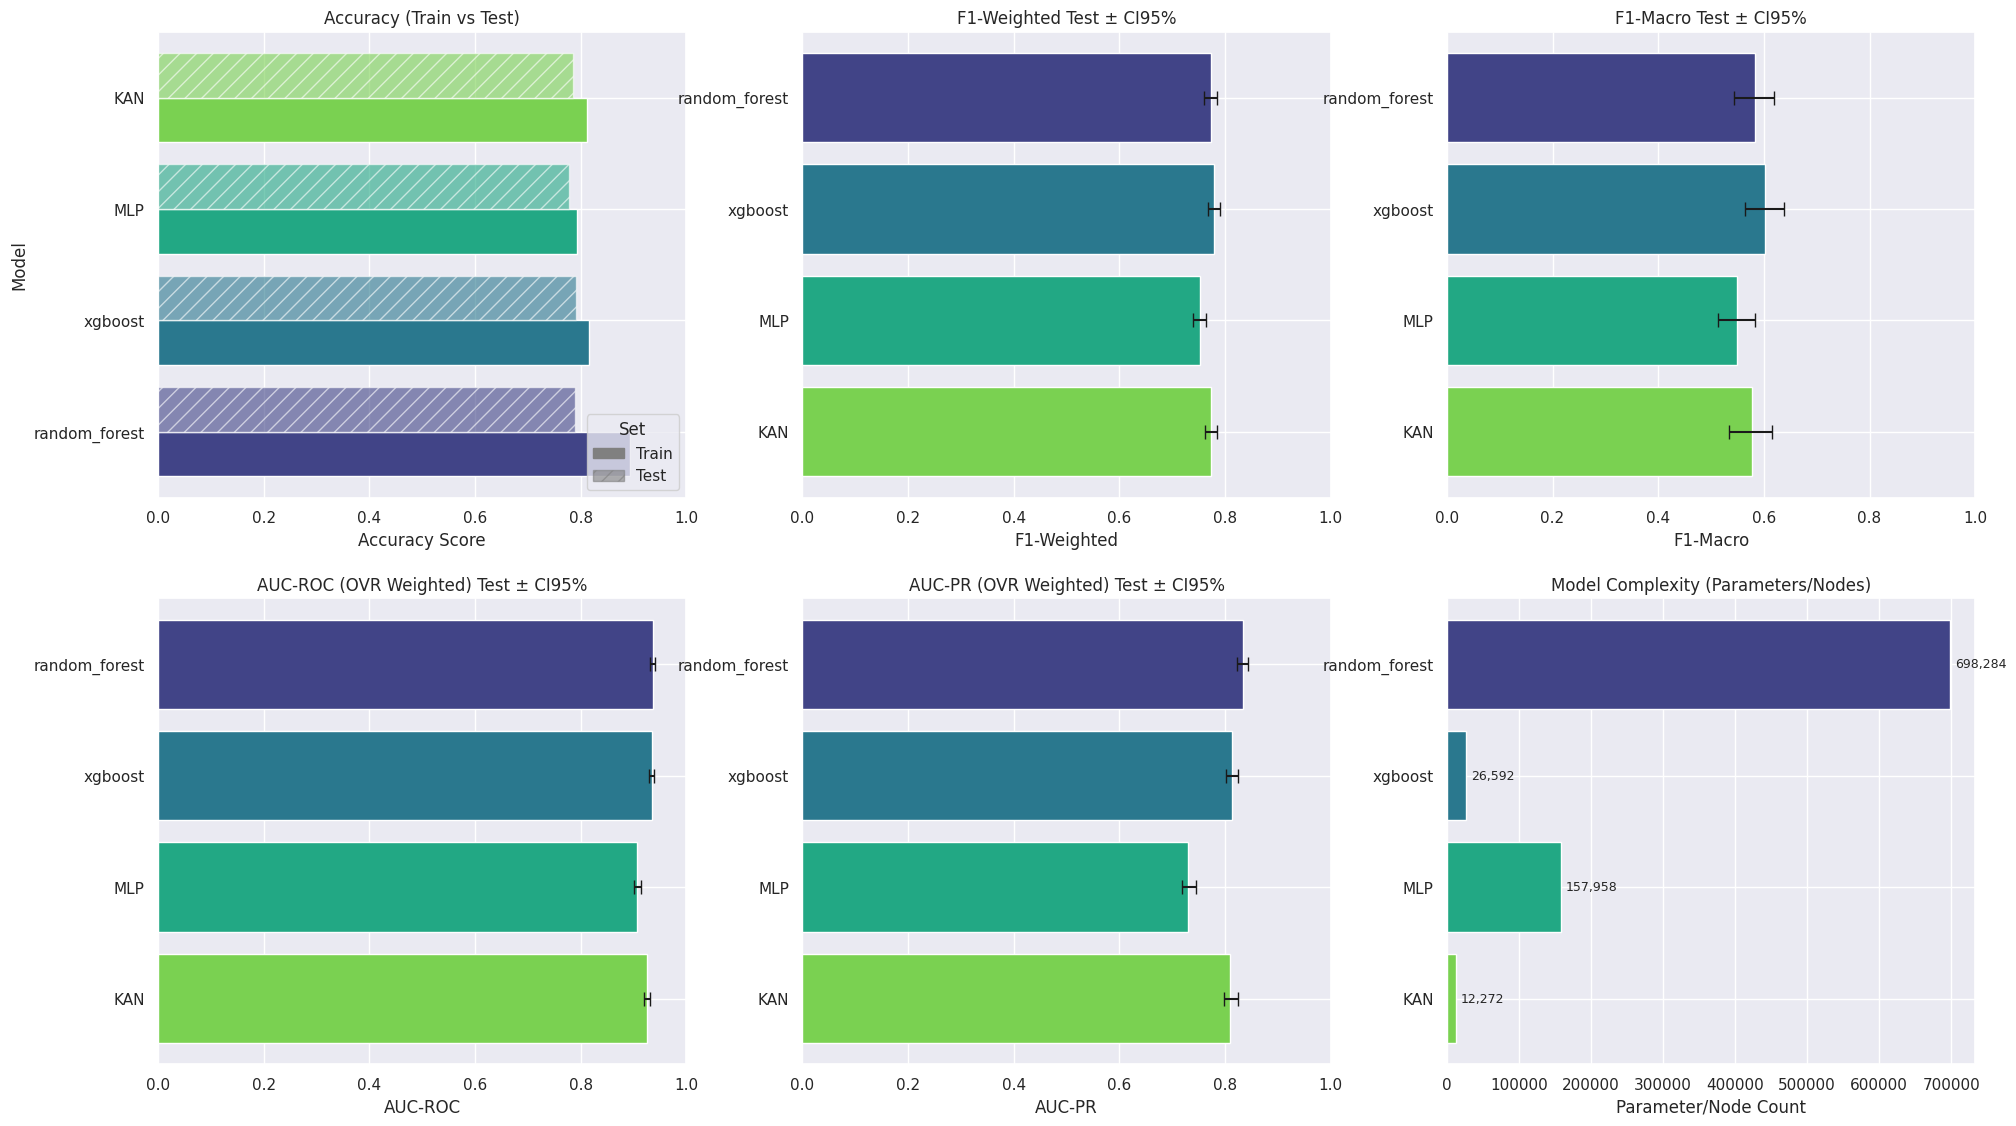

In [46]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [47]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_value = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_value:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> xgboost         (score: 3.400)
Complexity Weighted (1:2) -> KAN             (score: 4.800)
Extreme Complexity (1:3)  -> KAN             (score: 5.800)
Pareto Approach (40:60)   -> xgboost         (score: 0.200)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
KAN,12272,2.8,1,2,1,2
xgboost,26592,1.4,2,1,2,1
random_forest,698284,1.8,3,3,4,3
MLP,157958,4.0,4,4,3,4



RECOMMENDATION
   RECOMMENDED MODEL: KAN
   Reason: Best balance between performance and complexity
   Parameters: 12,272
   F1-Weighted Score: 0.7740
   Complexity-Weighted Rank Score: 4.800

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. KAN             | Params:   12,272 | F1: 0.7740 | Score: 4.800
   2. xgboost         | Params:   26,592 | F1: 0.7783 | Score: 5.400
   3. random_forest   | Params:  698,284 | F1: 0.7731 | Score: 9.800


# Ablation Study MLP e KAN

=== STANDALONE MLP/KAN PRUNING STUDY ===

=== Standalone L1 Pruning Study for MLP ===
NOTA: MLP è un modello MLP standalone
Total Parameters: 157,958

Testing MLP pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 157,958 / 157,958
  Compression: 1.00x
  Accuracy: 0.7773
  F1-Weighted: 0.7524

Testing MLP pruning ratio: 0.1000


  Applied L1 pruning to standalone MLP with ratio: 0.100
  Sparsity: 0.100
  Active params: 142,162 / 157,958
  Compression: 1.11x
  Accuracy: 0.7773
  F1-Weighted: 0.7524

Testing MLP pruning ratio: 0.2000
  Applied L1 pruning to standalone MLP with ratio: 0.200
  Sparsity: 0.200
  Active params: 126,366 / 157,958
  Compression: 1.25x
  Accuracy: 0.7778
  F1-Weighted: 0.7524

Testing MLP pruning ratio: 0.3000
  Applied L1 pruning to standalone MLP with ratio: 0.300
  Sparsity: 0.300
  Active params: 110,571 / 157,958
  Compression: 1.43x
  Accuracy: 0.7758
  F1-Weighted: 0.7516

Testing MLP pruning ratio: 0.5000
  Applied L1 pruning to standalone MLP with ratio: 0.500
  Sparsity: 0.500
  Active params: 78,979 / 157,958
  Compression: 2.00x
  Accuracy: 0.7808
  F1-Weighted: 0.7555

Testing MLP pruning ratio: 0.7000
  Applied L1 pruning to standalone MLP with ratio: 0.700
  Sparsity: 0.700
  Active params: 47,387 / 157,958
  Compression: 3.33x
  Accuracy: 0.7496
  F1-Weighted: 0.7039

T

  Sparsity: 0.800
  Active params: 31,592 / 157,958
  Compression: 5.00x
  Accuracy: 0.6940
  F1-Weighted: 0.6442

Testing MLP pruning ratio: 0.9000
  Applied L1 pruning to standalone MLP with ratio: 0.900
  Sparsity: 0.900
  Active params: 15,796 / 157,958
  Compression: 10.00x
  Accuracy: 0.5166
  F1-Weighted: 0.3758

Testing MLP pruning ratio: 0.9500
  Applied L1 pruning to standalone MLP with ratio: 0.950
  Sparsity: 0.950
  Active params: 7,898 / 157,958
  Compression: 20.00x
  Accuracy: 0.4947
  F1-Weighted: 0.3274

=== Standalone L1 Pruning Study for KAN ===
NOTA: KAN è un modello KAN standalone
Total Parameters: 12,272

Testing KAN pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 12,272 / 12,272
  Compression: 1.00x
  Accuracy: 0.7852
  F1-Weighted: 0.7740

Testing KAN pruning ratio: 0.1000


  Applied L1 pruning to standalone KAN with ratio: 0.100
  Sparsity: 0.108
  Active params: 11,894 / 12,272
  Compression: 1.03x
  Accuracy: 0.7852
  F1-Weighted: 0.7740

Testing KAN pruning ratio: 0.2000
  Applied L1 pruning to standalone KAN with ratio: 0.200
  Sparsity: 0.215
  Active params: 10,573 / 12,272
  Compression: 1.16x
  Accuracy: 0.7854
  F1-Weighted: 0.7741

Testing KAN pruning ratio: 0.3000
  Applied L1 pruning to standalone KAN with ratio: 0.300


  Sparsity: 0.323
  Active params: 9,251 / 12,272
  Compression: 1.33x
  Accuracy: 0.7850
  F1-Weighted: 0.7734

Testing KAN pruning ratio: 0.5000
  Applied L1 pruning to standalone KAN with ratio: 0.500
  Sparsity: 0.538
  Active params: 6,608 / 12,272
  Compression: 1.86x
  Accuracy: 0.7869
  F1-Weighted: 0.7724

Testing KAN pruning ratio: 0.7000
  Applied L1 pruning to standalone KAN with ratio: 0.700
  Sparsity: 0.754
  Active params: 3,965 / 12,272
  Compression: 3.10x
  Accuracy: 0.7995
  F1-Weighted: 0.8017

Testing KAN pruning ratio: 0.8000
  Applied L1 pruning to standalone KAN with ratio: 0.800


  Sparsity: 0.862
  Active params: 2,643 / 12,272
  Compression: 4.64x
  Accuracy: 0.7596
  F1-Weighted: 0.7722

Testing KAN pruning ratio: 0.9000
  Applied L1 pruning to standalone KAN with ratio: 0.900
  Sparsity: 0.969
  Active params: 1,322 / 12,272
  Compression: 9.28x
  Accuracy: 0.6606
  F1-Weighted: 0.6854

Testing KAN pruning ratio: 0.9500
  Applied L1 pruning to standalone KAN with ratio: 0.950
  Sparsity: 1.023
  Active params: 661 / 12,272
  Compression: 18.57x
  Accuracy: 0.3236
  F1-Weighted: 0.3242


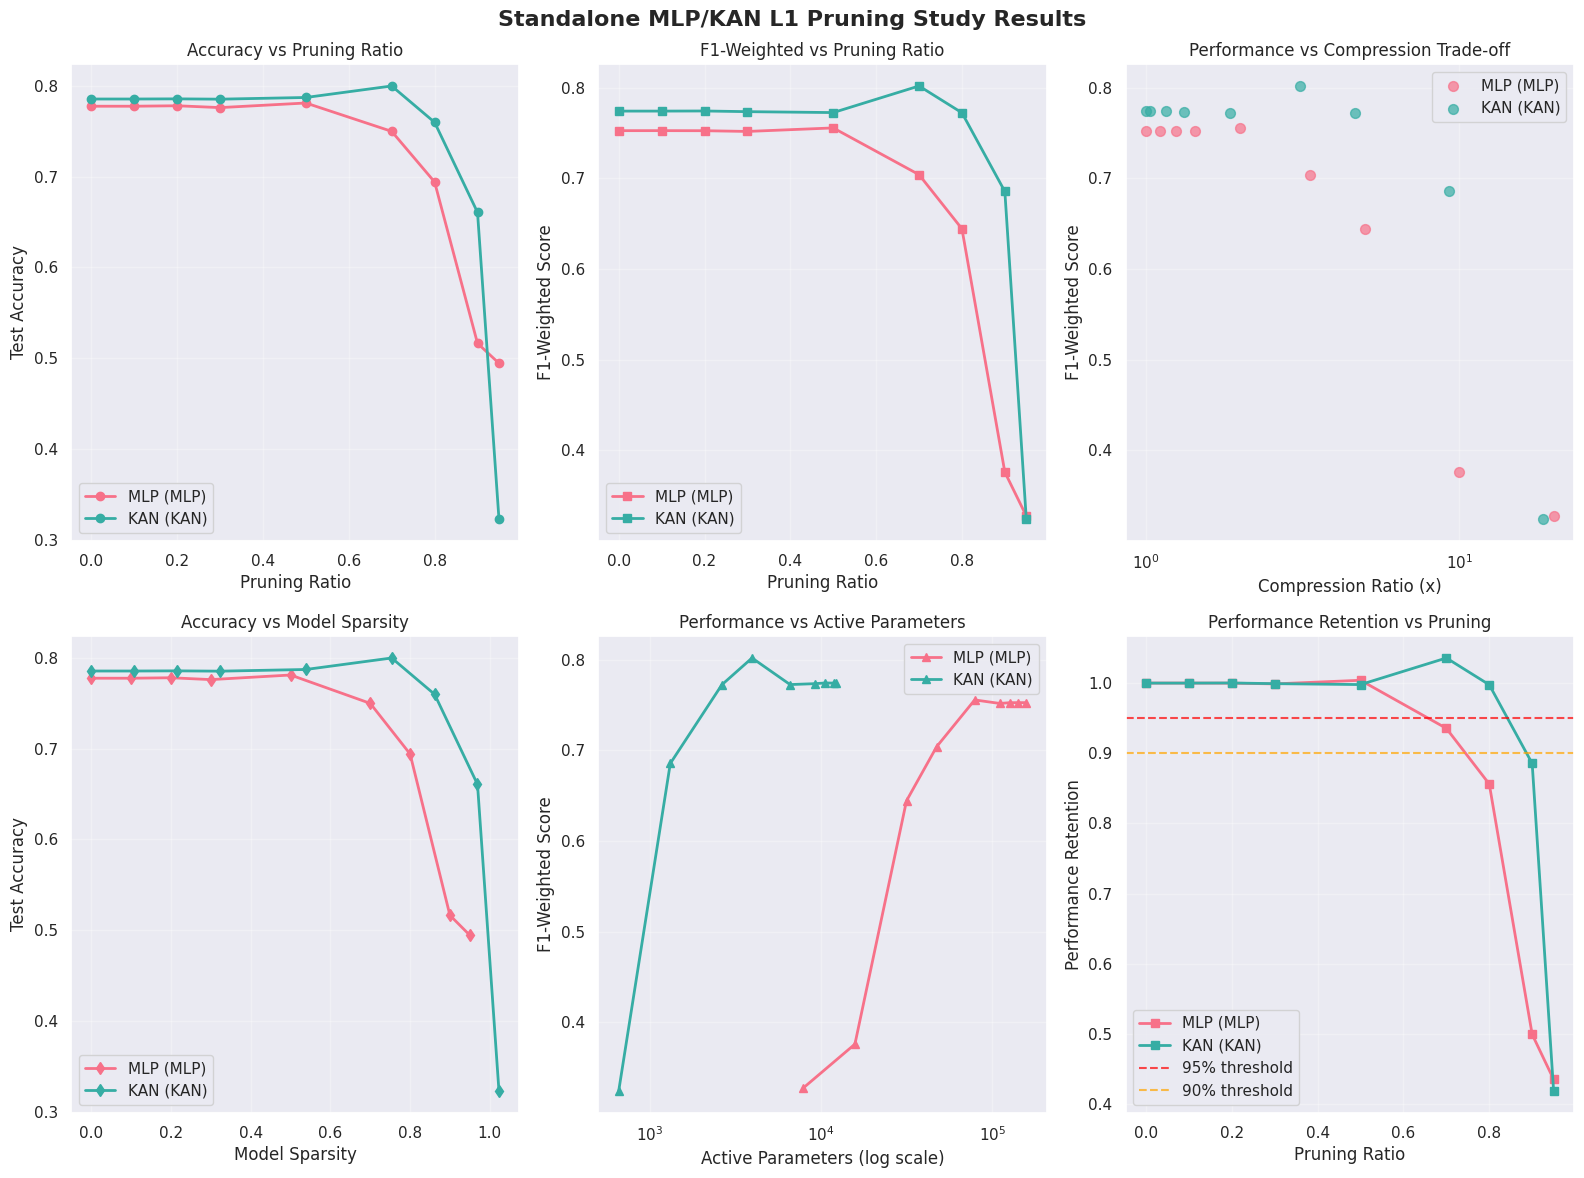


STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT

MLP Results:
--------------------------------------------------
Model Type: MLP
Total Parameters: 157,958
Baseline F1-Weighted: 0.7524
Significant degradation starts at: 70.0% pruning

Best trade-off point:
  Pruning ratio: 50.0%
  Compression: 2.0x
  F1_Weighted: 0.7555
  Performance loss: -0.4%

Maximum compression achieved: 20.0x

KAN Results:
--------------------------------------------------
Model Type: KAN
Total Parameters: 12,272
Baseline F1-Weighted: 0.7740
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 80.0%
  Compression: 4.6x
  F1_Weighted: 0.7722
  Performance loss: 0.2%

Maximum compression achieved: 18.6x

COMPARATIVE SUMMARY TABLE - STANDALONE MODELS
Model Type Pruning_Ratio Compression F1_Score Perf_Loss
  MLP  MLP           30%        1.4x   0.7516      0.1%
  MLP  MLP           50%        2.0x   0.7555     -0.4%
  MLP  MLP           70%        3.3x   0.7039      6.5%
  ML

,model_name,model_type,pruning_ratio,sparsity,total_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,MLP,MLP,0.00,0.000000,157958,157958,1.000000,0.777272,0.752432,0.548258,0.907018,0.730246
1,MLP,MLP,0.10,0.100001,157958,142162,1.111113,0.777272,0.752449,0.546221,0.907034,0.730326
2,MLP,MLP,0.20,0.200003,157958,126366,1.250004,0.777778,0.752373,0.541521,0.907089,0.730471
3,MLP,MLP,0.30,0.299997,157958,110571,1.428566,0.775755,0.751567,0.536772,0.906462,0.729139
4,MLP,MLP,0.50,0.500000,157958,78979,2.000000,0.780813,0.755450,0.531748,0.905168,0.727550
5,MLP,MLP,0.70,0.700003,157958,47387,3.333361,0.749621,0.703899,0.450432,0.896627,0.704484
6,MLP,MLP,0.80,0.799997,157958,31592,4.999937,0.693981,0.644182,0.344144,0.888596,0.671934
7,MLP,MLP,0.90,0.899999,157958,15796,9.999873,0.516608,0.375757,0.140006,0.862806,0.657263
8,MLP,MLP,0.95,0.949999,157958,7898,19.999747,0.494689,0.327449,0.110321,0.617362,0.412634
9,KAN,KAN,0.00,0.000000,12272,12272,1.000000,0.785196,0.774011,0.576962,0.926277,0.810046


In [48]:
class StandalonePruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità per modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                # Calcola parametri totali KAN usando count_params esistente
                total_params = count_params(model)

                # Conta i parametri zero nella componente KAN
                zero_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        # Accedi ai coefficienti spline (coef parameter)
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            zero_params += float(torch.sum(layer.coef == 0))

                return zero_params / total_params if total_params > 0 else 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0

        else:
            # Modello MLP standalone
            zero_params = 0
            total_params = count_params(model)

            # Conta parametri zero in tutti i layer Linear
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi nei modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                active_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            active_params += float(torch.sum(layer.coef != 0))

                return int(active_params)
            except:
                return count_params(model)

        else:
            # Modello MLP standalone
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))

            return int(active_params)


    def apply_l1_pruning_standalone(self, model, pruning_ratio):
        """Applica L1 norm pruning a modelli MLP/KAN standalone"""
        pruned_model = copy.deepcopy(model)

        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                if pruning_ratio == 0.0:
                    return pruned_model

                # Colleziona tutti i parametri KAN per L1 pruning globale
                kan_modules_to_prune = []
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = pruned_model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            temp_module = torch.nn.Linear(1, 1, bias=False)
                            temp_module.weight = torch.nn.Parameter(layer.coef.view(-1, 1))
                            kan_modules_to_prune.append((temp_module, 'weight'))


                if kan_modules_to_prune:
                    # Applica L1 pruning globale sui parametri KAN
                    prune.global_unstructured(
                        kan_modules_to_prune,
                        pruning_method=prune.L1Unstructured,
                        amount=pruning_ratio,
                    )

                    # Applica le maschere ai coefficienti originali
                    idx = 0
                    for i in range(len(model.width) - 1):
                        if i < len(model.act_fun):
                            layer = pruned_model.act_fun[i]
                            if hasattr(layer, 'coef') and layer.coef is not None:
                                original_shape = layer.coef.shape
                                mask = kan_modules_to_prune[idx][0].weight_mask.view(original_shape)
                                layer.coef.data = layer.coef.data * mask
                                idx += 1

                    # Rimuove le maschere temporanee
                    for module, param_name in kan_modules_to_prune:
                        prune.remove(module, param_name)

                print(f"  Applied L1 pruning to standalone KAN with ratio: {pruning_ratio:.3f}")
                return pruned_model

            except Exception as e:
                print(f"  Error during KAN L1 pruning: {e}")
                return model

        else:
            # Modello MLP standalone
            modules_to_prune = []

            # Colleziona tutti i layer Linear
            for module in pruned_model.modules():
                if isinstance(module, torch.nn.Linear):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            if modules_to_prune:
                # Applica L1 pruning globale
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rende permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

            print(f"  Applied L1 pruning to standalone MLP with ratio: {pruning_ratio:.3f}")
            return pruned_model


    def evaluate_pruned_model(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello pruned su dati tabulari"""
        # Ensure the model is on the correct device
        model.to(self.device)
        model.eval()

        # Converte in tensori, se necessario, e sposta sul device
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.FloatTensor(X_test).to(self.device)
        else:
            X_test = X_test.to(self.device)

        if not isinstance(y_test, torch.Tensor):
            y_test = torch.LongTensor(y_test).to(self.device)
        else:
             y_test = y_test.to(self.device)

        if not isinstance(X_train, torch.Tensor):
            X_train = torch.FloatTensor(X_train).to(self.device)
        else:
            X_train = X_train.to(self.device)

        if not isinstance(y_train, torch.Tensor):
            y_train = torch.LongTensor(y_train).to(self.device)
        else:
            y_train = y_train.to(self.device)


        # Predizioni
        with torch.no_grad():
            # Test set
            outputs_test = model(X_test)
            y_pred_test = torch.argmax(outputs_test, dim=1)
            y_proba_test = F.softmax(outputs_test, dim=1)

            # Train set
            outputs_train = model(X_train)
            y_pred_train = torch.argmax(outputs_train, dim=1)

        # Converte in NumPy per le metriche
        y_pred_test = y_pred_test.cpu().numpy()
        y_true_test = y_test.cpu().numpy()
        y_proba_test = y_proba_test.cpu().numpy()
        y_pred_train = y_pred_train.cpu().numpy()
        y_true_train = y_train.cpu().numpy()


        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }


    def run_standalone_pruning_study(self, model, model_name, X_test, y_test, X_train, y_train,
                                   pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con L1 pruning su modelli standalone MLP/KAN
        """
        print(f"\n=== Standalone L1 Pruning Study for {model_name} ===")

        # Determina il tipo di modello
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            model_type = "KAN"
            print(f"NOTA: {model_name} è un modello KAN standalone")
        else:
            model_type = "MLP"
            print(f"NOTA: {model_name} è un modello MLP standalone")

        # Parametri totali usando count_params
        total_params = count_params(model)
        print(f"Total Parameters: {total_params:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting {model_type} pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = total_params
            else:
                # Applica L1 pruning
                pruned_model = self.apply_l1_pruning_standalone(model, pruning_ratio)
                pruned_model.to(self.device)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Calcola statistiche di compressione
            compression_ratio = total_params / active_params if active_params > 0 else float('inf')

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': model_type,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_params': total_params,
                'active_params': active_params,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {total_params:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")


    def plot_standalone_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli standalone
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Standalone MLP/KAN L1 Pruning Study Results', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Performance vs Compression Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({model_type})', color=colors[i], s=50, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 4: Sparsity vs Performance
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['sparsity'], model_data['accuracy'],
                   marker='d', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Model Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: Active Parameters vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.semilogx(model_data['active_params'], model_data['f1_weighted'],
                       marker='^', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters (log scale)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Active Parameters')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance Retention
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            model_type = model_data.iloc[0]['model_type']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_standalone_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning standalone
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_params = baseline_row['total_params']
            model_type = baseline_row['model_type']

            print(f"Model Type: {model_type}")
            print(f"Total Parameters: {total_params:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - STANDALONE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]
            model_type = baseline['model_type']

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Type': model_type,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

print("=== STANDALONE MLP/KAN PRUNING STUDY ===")

standalone_pruning_study = StandalonePruningAblationStudy(device=device)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_mlp,
    model_name='MLP',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_kan,
    model_name='KAN',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.plot_standalone_pruning_results()
standalone_pruning_study.generate_standalone_pruning_report()

results_df = pd.DataFrame(standalone_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(results_df)} rows")
print("\nPruning results:")
display(results_df)

# Ablation Study RandomForest e XGBoost

In [49]:
# Ablation Study Ensemble Pruning: Random Forest e XGBoost

class EnsemblePruningAblationStudy:
    def __init__(self):
        self.pruning_results = []

    def rank_based_pruning_rf(self, rf_model, pruning_ratio):
        """
        Implementa Rank-Based Pruning per Random Forest.
        Rimuove gli alberi con le feature importance più basse.
        """
        if pruning_ratio == 0.0:
            return rf_model, list(range(len(rf_model.estimators_)))

        # Calcola l'importanza di ogni albero basata sulla media delle feature importance
        tree_importances = []
        for i, tree in enumerate(rf_model.estimators_):
            # L'importanza dell'albero è la somma delle importanze delle sue feature
            tree_importance = np.sum(tree.feature_importances_)
            tree_importances.append((i, tree_importance))

        # Ordina gli alberi per importanza (decrescente)
        tree_importances.sort(key=lambda x: x[1], reverse=True)

        # Calcola quanti alberi mantenere
        n_trees_to_keep = max(1, int(len(rf_model.estimators_) * (1 - pruning_ratio)))

        # Seleziona gli indici degli alberi da mantenere
        selected_indices = [idx for idx, _ in tree_importances[:n_trees_to_keep]]
        selected_indices.sort()  # Mantieni l'ordine originale

        # Crea un nuovo modello con solo gli alberi selezionati
        pruned_rf = copy.deepcopy(rf_model)
        pruned_rf.estimators_ = [rf_model.estimators_[i] for i in selected_indices]
        pruned_rf.n_estimators = len(selected_indices)

        return pruned_rf, selected_indices

    def cumulative_pruning_xgb(self, xgb_model, pruning_ratio):
        """
        Implementa Cumulative Pruning per XGBoost.
        Mantiene solo le prime iterazioni di boosting in base al pruning_ratio.
        """
        if pruning_ratio == 0.0:
            return xgb_model, list(range(xgb_model.n_estimators))

        # Ottieni il booster
        original_booster = xgb_model.get_booster()

        # Calcola il numero di alberi da mantenere
        total_trees = xgb_model.n_estimators
        num_classes = xgb_model.n_classes_
        total_rounds = total_trees // num_classes
        keep_rounds = max(1, int(total_rounds * (1 - pruning_ratio)))
        n_keep = keep_rounds * num_classes

        # Crea una copia del modello originale
        pruned_model = copy.deepcopy(xgb_model)
        pruned_model.n_estimators = n_keep

        def predict_pruned(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            predicted_labels = np.argmax(raw_predictions, axis=1)
            return predicted_labels

        def predict_proba(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            proba = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
            return proba

        pruned_model.predict = types.MethodType(predict_pruned, pruned_model)
        pruned_model.predict_proba = types.MethodType(predict_proba, pruned_model)

        selected_indices = list(range(n_keep))
        return pruned_model, selected_indices

    def evaluate_pruned_ensemble(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello ensemble pruned"""

        # Previsioni
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Calcola metriche
        accuracy = accuracy_score(y_test, y_pred_test)
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC (se il modello supporta predict_proba)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
                auc_pr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')
            else:
                auc_roc = np.nan
                auc_pr = np.nan
        except (ValueError, AttributeError):
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_rf_pruning_study(self, rf_model, model_name, X_test, y_test, X_train, y_train,
                           pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Rank-Based Pruning su Random Forest
        """
        print(f"\n=== Rank-Based Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = len(rf_model.estimators_)
        print(f"Total Trees: {total_trees:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting RF pruning ratio: {pruning_ratio:.2f}")

            # Applica rank-based pruning
            pruned_model, selected_indices = self.rank_based_pruning_rf(rf_model, pruning_ratio)

            # Calcola statistiche
            remaining_trees = len(selected_indices)
            compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

            # Valuta prestazioni
            metrics = self.evaluate_pruned_ensemble(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': 'Random Forest',
                'pruning_method': 'Rank-Based',
                'pruning_ratio': pruning_ratio,
                'total_trees': total_trees,
                'remaining_trees': remaining_trees,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def run_xgb_pruning_study(self, xgb_model, model_name, X_test, y_test, X_train, y_train,
                            pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Cumulative Pruning su XGBoost
        """
        print(f"\n=== Cumulative Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = xgb_model.n_estimators
        print(f"Total Trees: {total_trees:,}")
        print(f"Number of Classes: {xgb_model.n_classes_}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting XGB pruning ratio: {pruning_ratio:.2f}")

            try:
                # Applica cumulative pruning
                pruned_model, selected_indices = self.cumulative_pruning_xgb(xgb_model, pruning_ratio)

                # Calcola statistiche
                remaining_trees = len(selected_indices)
                compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

                # Valuta prestazioni
                metrics = self.evaluate_pruned_ensemble(
                    pruned_model, model_name, X_test, y_test, X_train, y_train
                )

                # Salva risultati
                result = {
                    'model_name': model_name,
                    'model_type': 'XGBoost',
                    'pruning_method': 'Cumulative',
                    'pruning_ratio': pruning_ratio,
                    'total_trees': total_trees,
                    'remaining_trees': remaining_trees,
                    'compression_ratio': compression_ratio,
                    'accuracy': metrics['accuracy'],
                    'f1_weighted': metrics['f1_weighted'],
                    'f1_macro': metrics['f1_macro'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr']
                }

                self.pruning_results.append(result)

                print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
                print(f"  Compression: {compression_ratio:.2f}x")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

            except Exception as e:
                print(f"  Error during XGB pruning at ratio {pruning_ratio}: {e}")
                continue

    def plot_ensemble_pruning_results(self, figsize=(18, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli ensemble
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('Ensemble Pruning Study Results - Random Forest & XGBoost',
                     fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("Set1", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='^', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: Performance vs Compression Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({method})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 5: Remaining Trees vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.semilogx(model_data['remaining_trees'], model_data['accuracy'],
                       marker='d', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Remaining Trees (log scale)')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Remaining Trees')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: AUC-ROC vs Pruning Ratio
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='*', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 7: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Trees Reduction vs Performance Loss
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_loss = (baseline_f1 - model_data['f1_weighted']) / baseline_f1 * 100
            trees_reduction = (1 - model_data['remaining_trees'] / model_data['total_trees']) * 100
            ax.plot(trees_reduction, performance_loss,
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Trees Reduction (%)')
        ax.set_ylabel('Performance Loss (%)')
        ax.set_title('Trees Reduction vs Performance Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 9: Efficiency Comparison
        ax = axes[2, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            baseline_trees = model_data.iloc[0]['total_trees']
            baseline_f1 = model_data.iloc[0]['f1_weighted']

            # Calcola l'efficienza come F1-score per albero
            efficiency = model_data['f1_weighted'] / (model_data['remaining_trees'] / baseline_trees)
            ax.plot(model_data['pruning_ratio'], efficiency,
                   marker='x', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Efficiency (F1/Tree Fraction)')
        ax.set_title('Model Efficiency vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_ensemble_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning ensemble
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("ENSEMBLE PRUNING STUDY - DETAILED REPORT")
        print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_trees = baseline_row['total_trees']
            model_type = baseline_row['model_type']
            pruning_method = baseline_row['pruning_method']

            print(f"Model Type: {model_type}")
            print(f"Pruning Method: {pruning_method}")
            print(f"Total Trees: {total_trees:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Trees: {best_tradeoff['remaining_trees']:,} / {total_trees:,}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    trees_reduction = ((baseline['total_trees'] - closest['remaining_trees']) / baseline['total_trees']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Method': baseline['pruning_method'],
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Trees_Kept': f"{closest['remaining_trees']:,}",
                        'Trees_Reduction': f"{trees_reduction:.0f}%",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

ENSEMBLE PRUNING ABLATION STUDY
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning
Random Forest model extracted successfully

=== Rank-Based Pruning Study for Random Forest ===
Total Trees: 200

Testing RF pruning ratio: 0.00


  Remaining trees: 200 / 200
  Compression: 1.00x
  Accuracy: 0.0776
  F1-Weighted: 0.0604

Testing RF pruning ratio: 0.10


  Remaining trees: 180 / 200
  Compression: 1.11x
  Accuracy: 0.0771
  F1-Weighted: 0.0603

Testing RF pruning ratio: 0.20


  Remaining trees: 160 / 200
  Compression: 1.25x
  Accuracy: 0.0772
  F1-Weighted: 0.0603

Testing RF pruning ratio: 0.30


  Remaining trees: 140 / 200
  Compression: 1.43x
  Accuracy: 0.0760
  F1-Weighted: 0.0597

Testing RF pruning ratio: 0.40


  Remaining trees: 120 / 200
  Compression: 1.67x
  Accuracy: 0.0774
  F1-Weighted: 0.0610

Testing RF pruning ratio: 0.50


  Remaining trees: 100 / 200
  Compression: 2.00x
  Accuracy: 0.0776
  F1-Weighted: 0.0614

Testing RF pruning ratio: 0.60


  Remaining trees: 80 / 200
  Compression: 2.50x
  Accuracy: 0.0771
  F1-Weighted: 0.0609

Testing RF pruning ratio: 0.70


  Remaining trees: 60 / 200
  Compression: 3.33x
  Accuracy: 0.0784
  F1-Weighted: 0.0620

Testing RF pruning ratio: 0.80


  Remaining trees: 39 / 200
  Compression: 5.13x
  Accuracy: 0.0801
  F1-Weighted: 0.0637

Testing RF pruning ratio: 0.90


  Remaining trees: 19 / 200
  Compression: 10.53x
  Accuracy: 0.0821
  F1-Weighted: 0.0670

Testing RF pruning ratio: 0.95


  Remaining trees: 10 / 200
  Compression: 20.00x
  Accuracy: 0.0857
  F1-Weighted: 0.0714
XGBoost model extracted successfully

=== Cumulative Pruning Study for XGBoost ===
Total Trees: 100
Number of Classes: 6

Testing XGB pruning ratio: 0.00
  Remaining trees: 100 / 100
  Compression: 1.00x
  Accuracy: 0.7916
  F1-Weighted: 0.7783

Testing XGB pruning ratio: 0.10


  Remaining trees: 84 / 100
  Compression: 1.19x
  Accuracy: 0.7913
  F1-Weighted: 0.7808

Testing XGB pruning ratio: 0.20
  Remaining trees: 72 / 100
  Compression: 1.39x
  Accuracy: 0.7899
  F1-Weighted: 0.7805

Testing XGB pruning ratio: 0.30


  Remaining trees: 66 / 100
  Compression: 1.52x
  Accuracy: 0.7882
  F1-Weighted: 0.7799

Testing XGB pruning ratio: 0.40
  Remaining trees: 54 / 100
  Compression: 1.85x
  Accuracy: 0.7864
  F1-Weighted: 0.7811

Testing XGB pruning ratio: 0.50


  Remaining trees: 48 / 100
  Compression: 2.08x
  Accuracy: 0.7871
  F1-Weighted: 0.7837

Testing XGB pruning ratio: 0.60
  Remaining trees: 36 / 100
  Compression: 2.78x
  Accuracy: 0.7874
  F1-Weighted: 0.7866

Testing XGB pruning ratio: 0.70


  Remaining trees: 24 / 100
  Compression: 4.17x
  Accuracy: 0.7894
  F1-Weighted: 0.7917

Testing XGB pruning ratio: 0.80
  Remaining trees: 18 / 100
  Compression: 5.56x
  Accuracy: 0.7857
  F1-Weighted: 0.7882

Testing XGB pruning ratio: 0.90
  Remaining trees: 6 / 100
  Compression: 16.67x
  Accuracy: 0.7995
  F1-Weighted: 0.8049

Testing XGB pruning ratio: 0.95


  Remaining trees: 6 / 100
  Compression: 16.67x
  Accuracy: 0.7995
  F1-Weighted: 0.8049


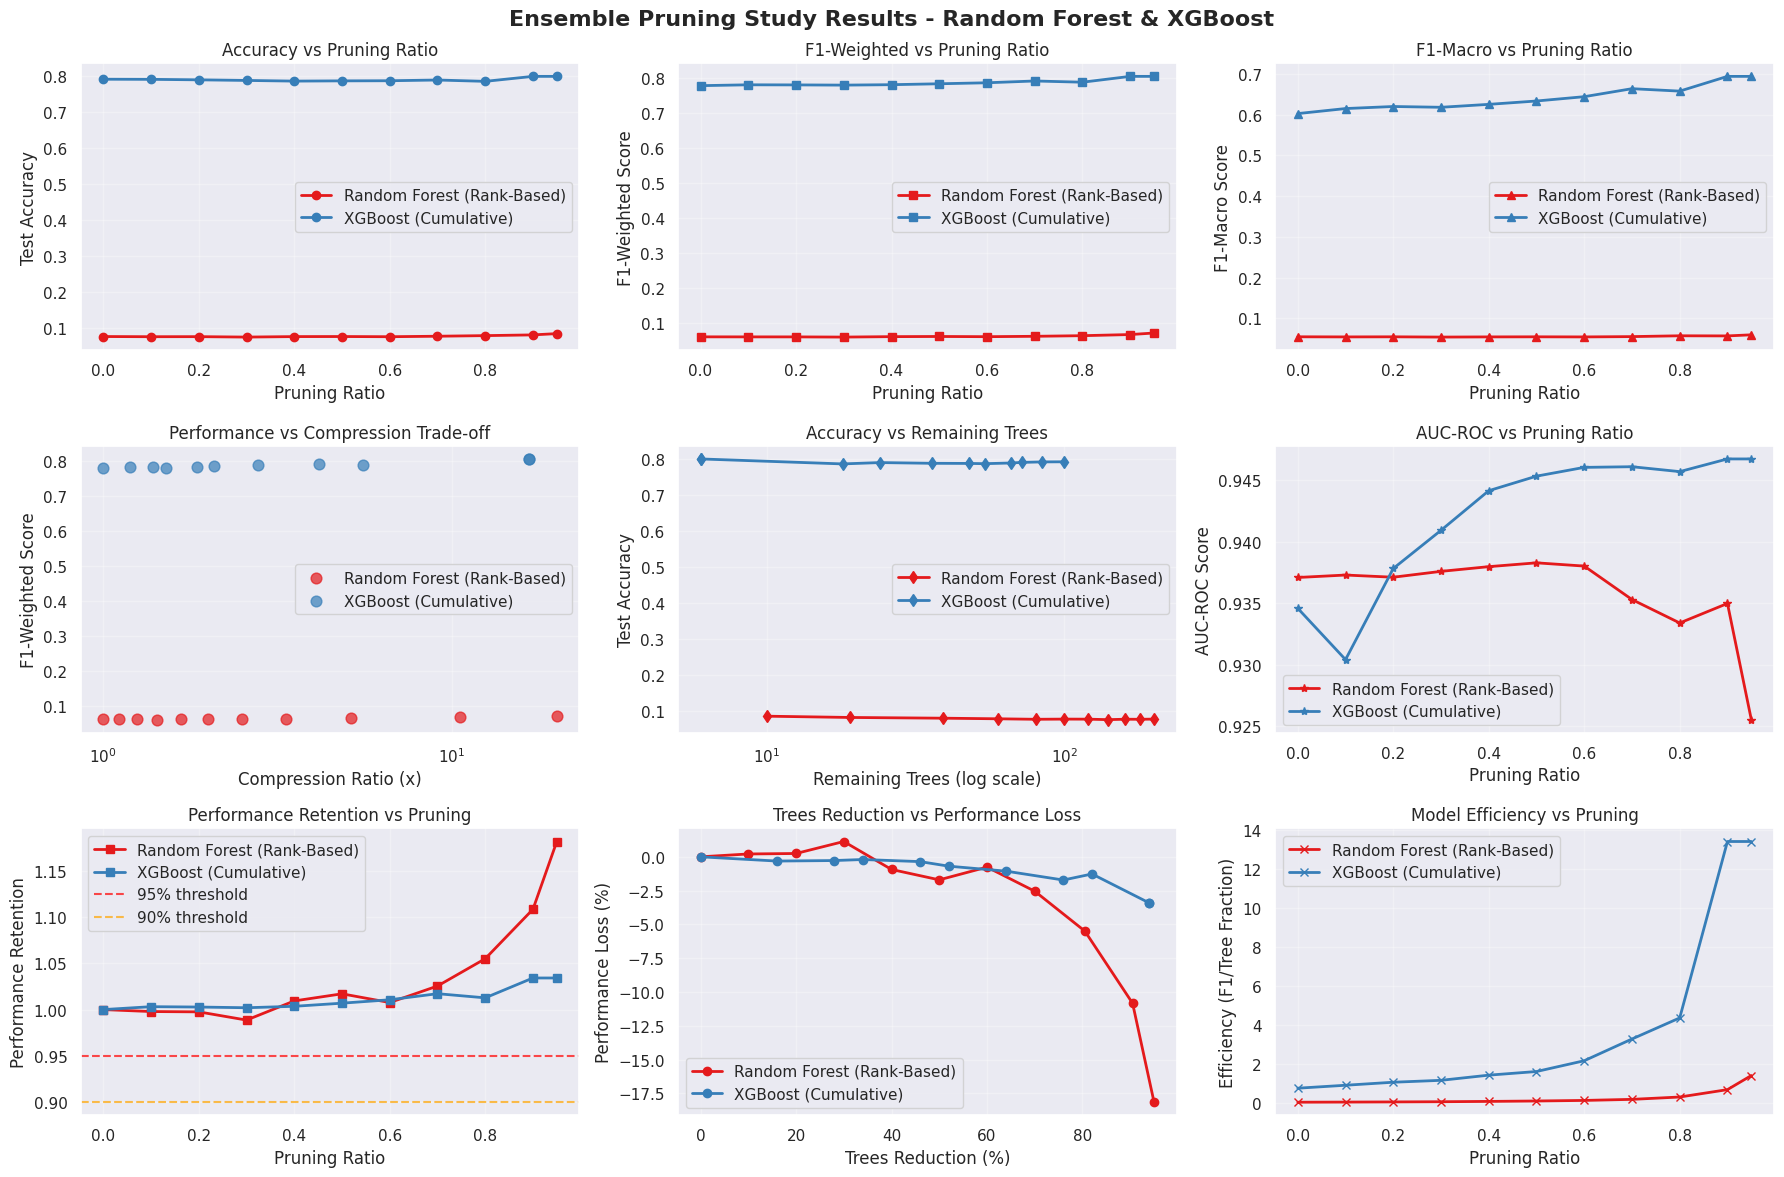


ENSEMBLE PRUNING STUDY - DETAILED REPORT
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning

Random Forest Results:
--------------------------------------------------
Model Type: Random Forest
Pruning Method: Rank-Based
Total Trees: 200
Baseline F1-Weighted: 0.0604
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 95.0%
  Trees: 10 / 200
  Compression: 20.0x
  F1_Weighted: 0.0714
  Performance loss: -18.1%

Maximum compression achieved: 20.0x

XGBoost Results:
--------------------------------------------------
Model Type: XGBoost
Pruning Method: Cumulative
Total Trees: 100
Baseline F1-Weighted: 0.7783
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 95.0%
  Trees: 6 / 100
  Compression: 16.7x
  F1_Weighted: 0.8049
  Performance loss: -3.4%

Maximum compression achieved: 16.7x

COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS
        Model     Method Pruning_Ratio Trees_Kept Trees_Reduc

,model_name,model_type,pruning_method,pruning_ratio,total_trees,remaining_trees,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,Random Forest,Random Forest,Rank-Based,0.00,200,200,1.000000,0.077559,0.060420,0.054293,0.937095,0.833166
1,Random Forest,Random Forest,Rank-Based,0.10,200,180,1.111111,0.077053,0.060293,0.054012,0.937293,0.833495
2,Random Forest,Random Forest,Rank-Based,0.20,200,160,1.250000,0.077221,0.060272,0.054246,0.937116,0.832471
3,Random Forest,Random Forest,Rank-Based,0.30,200,140,1.428571,0.076041,0.059736,0.053595,0.937592,0.833755
4,Random Forest,Random Forest,Rank-Based,0.40,200,120,1.666667,0.077390,0.060985,0.054028,0.937974,0.834968
5,Random Forest,Random Forest,Rank-Based,0.50,200,100,2.000000,0.077559,0.061449,0.054236,0.938285,0.835628
6,Random Forest,Random Forest,Rank-Based,0.60,200,80,2.500000,0.077053,0.060880,0.053993,0.938020,0.835232
7,Random Forest,Random Forest,Rank-Based,0.70,200,60,3.333333,0.078402,0.061957,0.054761,0.935304,0.829019
8,Random Forest,Random Forest,Rank-Based,0.80,200,39,5.128205,0.080088,0.063739,0.056772,0.933402,0.823241
9,Random Forest,Random Forest,Rank-Based,0.90,200,19,10.526316,0.082111,0.066964,0.056466,0.934985,0.827710


In [50]:
print("ENSEMBLE PRUNING ABLATION STUDY")
print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
print("="*100)

ensemble_pruning_study = EnsemblePruningAblationStudy()

pruning_ratios_ensemble = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

try:
    if 'tree' in gs_rf.best_estimator_.named_steps:
        rf_final_model = gs_rf.best_estimator_.named_steps['tree']
    else:
        raise ValueError("Random Forest model not found")

    print("Random Forest model extracted successfully")

    ensemble_pruning_study.run_rf_pruning_study(
        rf_model=rf_final_model,
        model_name='Random Forest',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with Random Forest model: {e}")

try:
    if 'xgb' in gs_xgb.best_estimator_.named_steps:
        xgb_final_model = gs_xgb.best_estimator_.named_steps['xgb']
    else:
        raise ValueError("XGBoost model not found")

    print("XGBoost model extracted successfully")

    ensemble_pruning_study.run_xgb_pruning_study(
        xgb_model=xgb_final_model,
        model_name='XGBoost',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with XGBoost model: {e}")

ensemble_pruning_study.plot_ensemble_pruning_results()
ensemble_pruning_study.generate_ensemble_pruning_report()

ensemble_results_df = pd.DataFrame(ensemble_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(ensemble_results_df)} rows")
print("\nPruning results:")
display(ensemble_results_df)

# Ablation Study Comparation

In [51]:
def compare_all_pruning_methods():
    """
    Compare pruning effectiveness across all model types
    """
    print("\n" + "="*120)
    print("COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS")
    print("="*120)

    # Collect data from both studies
    all_models_comparison = []

    # Neural network results
    for _, result in results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Neural Network',
                'Pruning_Method': 'L1 Norm',
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Components': f"{result['active_params']}/{result['total_params']}"
            })

    # Ensemble results
    for _, result in ensemble_results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            pruning_method = 'Rank-Based' if result['model_name'] == 'Random Forest' else 'Cumulative'
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Ensemble',
                'Pruning_Method': pruning_method,
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Trees': f"{result['remaining_trees']}/{result['total_trees']}"
            })

    if all_models_comparison:
        comparison_df = pd.DataFrame(all_models_comparison)

        # Create pivot table for better visualization
        pivot_accuracy = comparison_df.pivot_table(
            values='Accuracy_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_weighted = comparison_df.pivot_table(
            values='F1_Weighted_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_roc = comparison_df.pivot_table(
            values='AUC_ROC_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_pr = comparison_df.pivot_table(
            values='AUC_PR_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )

        print("\nAccuracy Performance Across Pruning Levels:")
        print(pivot_accuracy.round(4))

        print("\nF1 Weighted Performance Across Pruning Levels:")
        print(pivot_f1_weighted.round(4))

        print("\nAUC_ROC Weighted Performance Across Pruning Levels:")
        print(pivot_auc_roc.round(4))

        print("\nAUC_PR Weighted Performance Across Pruning Levels:")
        print(pivot_auc_pr.round(4))

        pruning_levels = [0.3, 0.5, 0.7, 0.9]

        print(f"\n{'='*120}")
        print("PERFORMANCE RETENTION AT DIFFERENT PRUNING LEVELS")
        print("="*120)

        for pruning_level in pruning_levels:
            print(f"\n{'-'*60}")
            print(f"PERFORMANCE RETENTION AT {int(pruning_level*100)}% PRUNING")
            print(f"{'-'*60}")

            retention_summary = []
            for model in comparison_df['Model'].unique():
                model_data = comparison_df[comparison_df['Model'] == model]
                baseline = model_data[model_data['Pruning_Ratio'] == 0.0]
                pruned = model_data[model_data['Pruning_Ratio'] == pruning_level]

                if len(baseline) > 0 and len(pruned) > 0:
                    baseline_acc = baseline.iloc[0]['Accuracy_Test']
                    pruned_acc = pruned.iloc[0]['Accuracy_Test']
                    retention = pruned_acc / baseline_acc if baseline_acc != 0 else 0

                    retention_summary.append({
                        'Model': model,
                        'Type': baseline.iloc[0]['Type'],
                        'Method': baseline.iloc[0]['Pruning_Method'],
                        'Baseline_Accuracy': baseline_acc,
                        'Pruned_Accuracy': pruned_acc,
                        'Retention': retention,
                        'Compression': pruned.iloc[0]['Compression']
                    })

            if retention_summary:
                retention_df = pd.DataFrame(retention_summary).sort_values('Retention', ascending=False)
                print(retention_df.round(4))

            best_model = retention_df.iloc[0]
            print(f"\nBEST PRUNING METHOD AT {int(pruning_level*100)}% LEVEL:")
            print(f"Model: {best_model['Model']} ({best_model['Type']})")
            print(f"Method: {best_model['Method']}")
            print(f"Performance Retention: {best_model['Retention']:.1%}")
            print(f"Compression Achieved: {best_model['Compression']:.1f}x")

    else:
        print("No pruning results available for comparison.")

# Run comprehensive comparison
compare_all_pruning_methods()

print("\n" + "="*120)
print("ABLATION STUDY COMPLETE")


COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS

Accuracy Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7  \
Model         Type           Pruning_Method                                   
KAN           Neural Network L1 Norm         0.7852  0.7850  0.7869  0.7995   
MLP           Neural Network L1 Norm         0.7773  0.7758  0.7808  0.7496   
Random Forest Ensemble       Rank-Based      0.0776  0.0760  0.0776  0.0784   
XGBoost       Ensemble       Cumulative      0.7916  0.7882  0.7871  0.7894   

Pruning_Ratio                                   0.9  
Model         Type           Pruning_Method          
KAN           Neural Network L1 Norm         0.6606  
MLP           Neural Network L1 Norm         0.5166  
Random Forest Ensemble       Rank-Based      0.0821  
XGBoost       Ensemble       Cumulative      0.7995  

F1 Weighted Performance Across Pruning Levels:
Pruning_Ratio                        